In [ ]:
import numpy as np
import random
import sys
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import cv2
from torchsummary import summary

In [ ]:
import gym
env = gym.make("Breakout-ramDeterministic-v4")


print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box(128,)
Action space: Discrete(4)


In [ ]:
cap=200000
batch_size=32
lr=1e-5
eps=1
n_ep=20000
gamma=0.99
no_of_actions=4
state_size=128


In [ ]:
class ReplayMemory:
    def __init__(self, max_size):
        self.buffer = [None] * max_size
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = random.sample(range(self.size), batch_size)
        return [self.buffer[index] for index in indices]

In [ ]:
 def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.uniform_(m.weight, -0.01, 0.01)
            m.bias.data.fill_(0.01)
            

In [ ]:
def plotter(s,p):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(s)), s)
        plt.ylabel('av_score')
        plt.xlabel('Episode*50')
        plt.show()

        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(p)), p)
        plt.ylabel('q_values')
        plt.xlabel('episode*20')
        plt.show()


In [ ]:
def save_model():
        model_save_name = 'breakout6.pt'
        path = F"/content/gdrive/My Drive/{model_save_name}" 
        checkpoint = {
                        'model_state_dict':agent.model.state_dict(),
                        'target_state_dict':agent.target.state_dict(),
                        'optimizer_state_dict': agent.optimizer.state_dict(),
                        'memory':agent.memory
                        }

        torch.save(checkpoint, path)
def save_model2():
        model_save_name = 'breakout7.pt'
        path = F"/content/gdrive/My Drive/{model_save_name}" 
        checkpoint = {
                        'model_state_dict':agent.model.state_dict(),
                        'target_state_dict':agent.target.state_dict(),
                        'optimizer_state_dict': agent.optimizer.state_dict(),
                        'memory':agent.memory
                        }

        torch.save(checkpoint, path)


In [ ]:
def load_tests():
    model_save_name = 'breakout_test.pt'
    per=torch.load(F"/content/gdrive/My Drive/{model_save_name}" )
    per=(per['test_states'])
    test_states= np.zeros((20000,512))
    test_states=np.concatenate(per, out=test_states)
    test_states=torch.from_numpy(test_states).float()
    return test_states


In [ ]:
class dqn(nn.Module):
    def __init__(self,state_size,no_of_actions):
        
        super().__init__()
        self.fc1 = nn.Linear(128*4, 256)
        self.fc2=nn.Linear(256,128)
        self.fc3=nn.Linear(128,64)
        self.fc4=nn.Linear(128,64)
        self.fc5 = nn.Linear(64, no_of_actions)
        self.fc6 = nn.Linear(64 , 1)

    def forward(self, x):
        out = self.fc1(x)
        out=F.relu(out)
        out = self.fc2(out)
        out=F.relu(out)
        V = F.relu(self.fc3(out))
        v =self.fc6(V)
        A=F.relu(self.fc4(out))
        a = self.fc5(A)
        q=v+(a-torch.mean(a, dim=1, keepdim=True))
        return q
    
   


In [ ]:
class agent:
    def __init__(self):
    
        self.memory=ReplayMemory(cap)
        self.model=dqn(state_size,no_of_actions)
        self.target=dqn(state_size,no_of_actions)
        self.target.apply(init_weights)
        self.model.apply(init_weights)
        self.optimizer=optim.Adam(self.model.parameters(),lr)
        self.x=0
      
    
    def remember(self,state,action,reward,next_state,done):
      
        self.memory.append([state,action,reward,next_state,done])
        
    def sample(self):
        
        experiences=self.memory.sample(batch_size)
        states = torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float()
        next_states =  torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)).float()
        return (states, actions, rewards, next_states, dones)
    
   
    def train(self):
        states, actions, rewards, next_states, dones = self.sample()
        Q=self.model(states).gather(1, actions)
        _,a=torch.max(self.model(next_states),1,keepdim=True)
        Q_next_state=self.target(next_states).gather(1, a)
        Q_target=rewards+gamma*(Q_next_state*(1-dones))
        loss=F.mse_loss(Q,Q_target)
        self.x+=1
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        if(self.x%10000==0):
            self.update(self.model,self.target)

   
    def action(self,state,eps):
       
        if random.random() > eps:
            with torch.no_grad():
                state= torch.from_numpy(state).float()
                action_values = self.model(state)
            action= (np.argmax(action_values).item())
        else:
            action= random.choice(np.arange(no_of_actions))
        return action
    
    def update(self,local,target):
         for target_param, local_param in zip(target.parameters(), local.parameters()):
            target_param.data.copy_(local_param.data )
    

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         131,328
            Linear-2               [-1, 1, 128]          32,896
            Linear-3                [-1, 1, 64]           8,256
            Linear-4                 [-1, 1, 1]              65
            Linear-5                [-1, 1, 64]           8,256
            Linear-6                 [-1, 1, 4]             260
Total params: 181,061
Trainable params: 181,061
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.69
Estimated Total Size (MB): 0.70
----------------------------------------------------------------
Game 1, Score = 0.0,Steps = 164, av_score=0.0
Game 2, Score = 1.0,Steps = 159, av_score=0.5
Game 3, Score = 1.0,Steps = 180, av_score=0.6666666666666666
Game 4, Score = 5

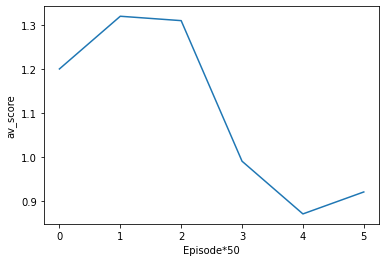

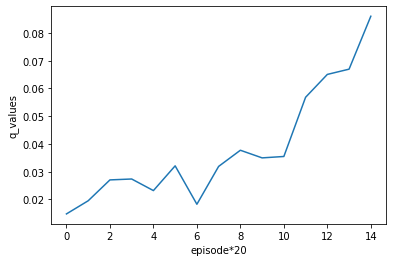

Game 301, Score = 0.0,Steps = 139, av_score=0.92
Game 302, Score = 2.0,Steps = 227, av_score=0.92
Game 303, Score = 1.0,Steps = 183, av_score=0.91
Game 304, Score = 1.0,Steps = 171, av_score=0.9
Game 305, Score = 1.0,Steps = 175, av_score=0.89
Game 306, Score = 0.0,Steps = 140, av_score=0.88
Game 307, Score = 0.0,Steps = 132, av_score=0.88
Game 308, Score = 2.0,Steps = 194, av_score=0.89
Game 309, Score = 1.0,Steps = 179, av_score=0.9
Game 310, Score = 1.0,Steps = 162, av_score=0.9
Game 311, Score = 2.0,Steps = 201, av_score=0.9
Game 312, Score = 0.0,Steps = 125, av_score=0.89
Game 313, Score = 0.0,Steps = 135, av_score=0.88
Game 314, Score = 1.0,Steps = 161, av_score=0.87
Game 315, Score = 2.0,Steps = 212, av_score=0.86
Game 316, Score = 3.0,Steps = 271, av_score=0.88
Game 317, Score = 3.0,Steps = 281, av_score=0.91
Game 318, Score = 2.0,Steps = 204, av_score=0.93
Game 319, Score = 3.0,Steps = 250, av_score=0.94
Game 320, Score = 1.0,Steps = 156, av_score=0.93
Game 321, Score = 1.0,St

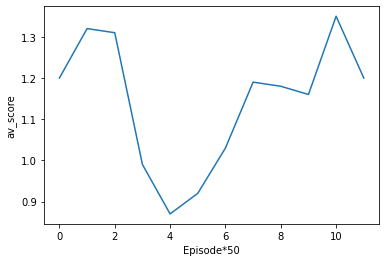

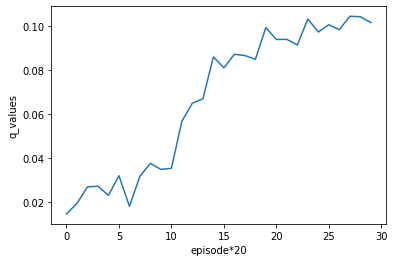

Game 601, Score = 2.0,Steps = 195, av_score=1.22
Game 602, Score = 0.0,Steps = 137, av_score=1.21
Game 603, Score = 0.0,Steps = 145, av_score=1.2
Game 604, Score = 0.0,Steps = 128, av_score=1.19
Game 605, Score = 1.0,Steps = 160, av_score=1.2
Game 606, Score = 0.0,Steps = 143, av_score=1.17
Game 607, Score = 0.0,Steps = 138, av_score=1.12
Game 608, Score = 0.0,Steps = 130, av_score=1.11
Game 609, Score = 1.0,Steps = 155, av_score=1.1
Game 610, Score = 4.0,Steps = 294, av_score=1.11
Game 611, Score = 0.0,Steps = 132, av_score=1.1
Game 612, Score = 0.0,Steps = 136, av_score=1.05
Game 613, Score = 1.0,Steps = 168, av_score=1.05
Game 614, Score = 0.0,Steps = 157, av_score=1.05
Game 615, Score = 2.0,Steps = 211, av_score=1.04
Game 616, Score = 3.0,Steps = 243, av_score=1.05
Game 617, Score = 0.0,Steps = 135, av_score=1.04
Game 618, Score = 2.0,Steps = 190, av_score=1.06
Game 619, Score = 3.0,Steps = 256, av_score=1.09
Game 620, Score = 3.0,Steps = 273, av_score=1.07
Game 621, Score = 0.0,St

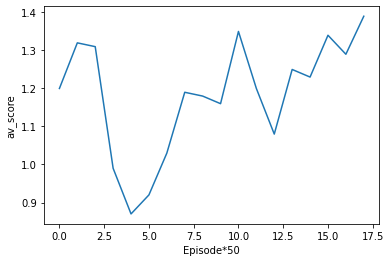

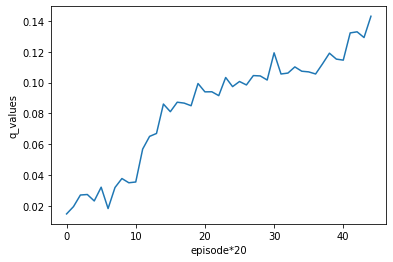

Game 901, Score = 2.0,Steps = 216, av_score=1.39
Game 902, Score = 2.0,Steps = 205, av_score=1.39
Game 903, Score = 0.0,Steps = 133, av_score=1.38
Game 904, Score = 1.0,Steps = 177, av_score=1.39
Game 905, Score = 1.0,Steps = 162, av_score=1.39
Game 906, Score = 2.0,Steps = 190, av_score=1.4
Game 907, Score = 1.0,Steps = 169, av_score=1.38
Game 908, Score = 0.0,Steps = 142, av_score=1.38
Game 909, Score = 2.0,Steps = 207, av_score=1.37
Game 910, Score = 1.0,Steps = 172, av_score=1.38
Game 911, Score = 0.0,Steps = 133, av_score=1.38
Game 912, Score = 2.0,Steps = 209, av_score=1.4
Game 913, Score = 7.0,Steps = 258, av_score=1.47
Game 914, Score = 1.0,Steps = 163, av_score=1.48
Game 915, Score = 2.0,Steps = 226, av_score=1.48
Game 916, Score = 1.0,Steps = 176, av_score=1.49
Game 917, Score = 4.0,Steps = 270, av_score=1.52
Game 918, Score = 2.0,Steps = 228, av_score=1.54
Game 919, Score = 2.0,Steps = 202, av_score=1.54
Game 920, Score = 1.0,Steps = 164, av_score=1.53
Game 921, Score = 1.0,

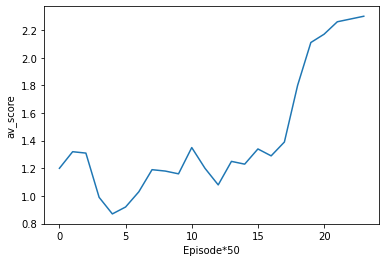

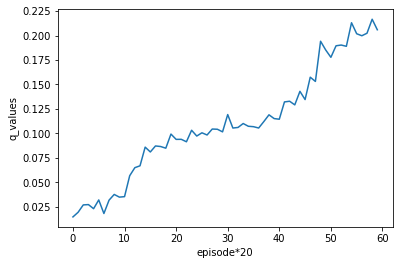

Game 1201, Score = 2.0,Steps = 206, av_score=2.31
Game 1202, Score = 3.0,Steps = 291, av_score=2.33
Game 1203, Score = 1.0,Steps = 162, av_score=2.31
Game 1204, Score = 1.0,Steps = 186, av_score=2.29
Game 1205, Score = 0.0,Steps = 141, av_score=2.28
Game 1206, Score = 2.0,Steps = 210, av_score=2.27
Game 1207, Score = 1.0,Steps = 176, av_score=2.27
Game 1208, Score = 3.0,Steps = 250, av_score=2.19
Game 1209, Score = 2.0,Steps = 196, av_score=2.21
Game 1210, Score = 2.0,Steps = 225, av_score=2.23
Game 1211, Score = 1.0,Steps = 161, av_score=2.24
Game 1212, Score = 4.0,Steps = 281, av_score=2.27
Game 1213, Score = 5.0,Steps = 332, av_score=2.3
Game 1214, Score = 2.0,Steps = 194, av_score=2.31
Game 1215, Score = 3.0,Steps = 225, av_score=2.33
Game 1216, Score = 4.0,Steps = 279, av_score=2.34
Game 1217, Score = 2.0,Steps = 224, av_score=2.34
Game 1218, Score = 4.0,Steps = 281, av_score=2.36
Game 1219, Score = 2.0,Steps = 188, av_score=2.37
Game 1220, Score = 3.0,Steps = 228, av_score=2.38
G

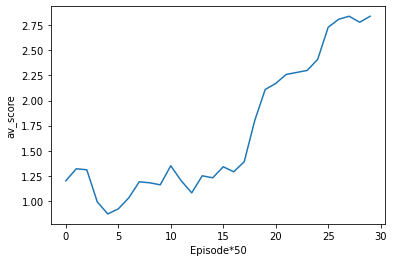

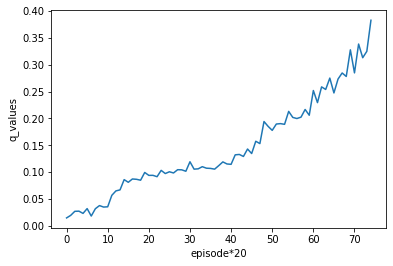

Game 1501, Score = 7.0,Steps = 410, av_score=2.9
Game 1502, Score = 9.0,Steps = 353, av_score=2.96
Game 1503, Score = 0.0,Steps = 123, av_score=2.93
Game 1504, Score = 3.0,Steps = 236, av_score=2.94
Game 1505, Score = 1.0,Steps = 155, av_score=2.94
Game 1506, Score = 6.0,Steps = 380, av_score=2.97
Game 1507, Score = 4.0,Steps = 270, av_score=2.98
Game 1508, Score = 3.0,Steps = 216, av_score=3.0
Game 1509, Score = 4.0,Steps = 247, av_score=3.02
Game 1510, Score = 3.0,Steps = 225, av_score=3.03
Game 1511, Score = 4.0,Steps = 250, av_score=3.03
Game 1512, Score = 7.0,Steps = 257, av_score=3.06
Game 1513, Score = 5.0,Steps = 315, av_score=3.09
Game 1514, Score = 4.0,Steps = 303, av_score=3.12
Game 1515, Score = 4.0,Steps = 272, av_score=3.15
Game 1516, Score = 3.0,Steps = 220, av_score=3.11
Game 1517, Score = 4.0,Steps = 269, av_score=3.13
Game 1518, Score = 2.0,Steps = 195, av_score=3.14
Game 1519, Score = 5.0,Steps = 339, av_score=3.18
Game 1520, Score = 4.0,Steps = 286, av_score=3.18
Ga

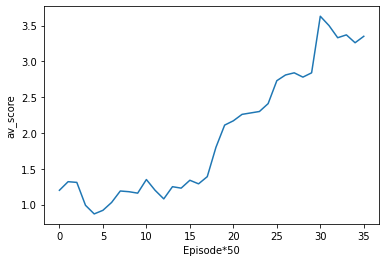

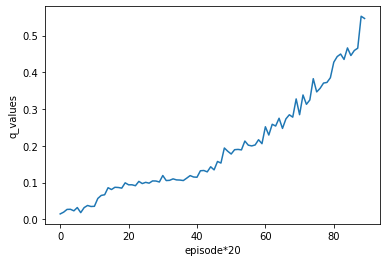

Game 1801, Score = 3.0,Steps = 242, av_score=3.36
Game 1802, Score = 5.0,Steps = 350, av_score=3.4
Game 1803, Score = 2.0,Steps = 187, av_score=3.41
Game 1804, Score = 3.0,Steps = 234, av_score=3.42
Game 1805, Score = 3.0,Steps = 215, av_score=3.42
Game 1806, Score = 2.0,Steps = 191, av_score=3.43
Game 1807, Score = 3.0,Steps = 216, av_score=3.4
Game 1808, Score = 2.0,Steps = 184, av_score=3.38
Game 1809, Score = 1.0,Steps = 153, av_score=3.37
Game 1810, Score = 3.0,Steps = 244, av_score=3.39
Game 1811, Score = 2.0,Steps = 185, av_score=3.37
Game 1812, Score = 3.0,Steps = 217, av_score=3.36
Game 1813, Score = 2.0,Steps = 186, av_score=3.35
Game 1814, Score = 3.0,Steps = 223, av_score=3.31
Game 1815, Score = 8.0,Steps = 306, av_score=3.37
Game 1816, Score = 3.0,Steps = 216, av_score=3.38
Game 1817, Score = 2.0,Steps = 186, av_score=3.32
Game 1818, Score = 3.0,Steps = 232, av_score=3.31
Game 1819, Score = 2.0,Steps = 185, av_score=3.31
Game 1820, Score = 2.0,Steps = 188, av_score=3.32
Ga

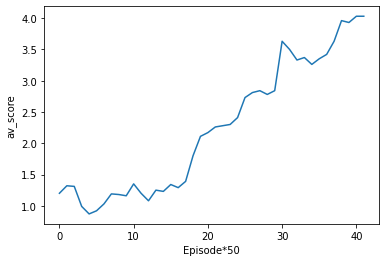

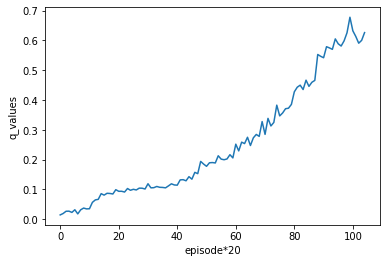

Game 2101, Score = 3.0,Steps = 237, av_score=4.03
Game 2102, Score = 2.0,Steps = 184, av_score=4.0
Game 2103, Score = 5.0,Steps = 323, av_score=4.03
Game 2104, Score = 5.0,Steps = 302, av_score=4.06
Game 2105, Score = 5.0,Steps = 291, av_score=4.05
Game 2106, Score = 2.0,Steps = 187, av_score=4.04
Game 2107, Score = 5.0,Steps = 322, av_score=4.07
Game 2108, Score = 7.0,Steps = 395, av_score=4.11
Game 2109, Score = 5.0,Steps = 314, av_score=4.03
Game 2110, Score = 2.0,Steps = 188, av_score=4.02
Game 2111, Score = 3.0,Steps = 216, av_score=3.98
Game 2112, Score = 5.0,Steps = 290, av_score=4.02
Game 2113, Score = 3.0,Steps = 218, av_score=4.02
Game 2114, Score = 3.0,Steps = 239, av_score=4.01
Game 2115, Score = 6.0,Steps = 354, av_score=3.99
Game 2116, Score = 2.0,Steps = 188, av_score=3.98
Game 2117, Score = 5.0,Steps = 360, av_score=3.98
Game 2118, Score = 1.0,Steps = 158, av_score=3.95
Game 2119, Score = 9.0,Steps = 332, av_score=4.01
Game 2120, Score = 3.0,Steps = 256, av_score=4.01
G

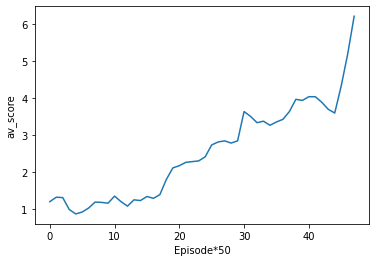

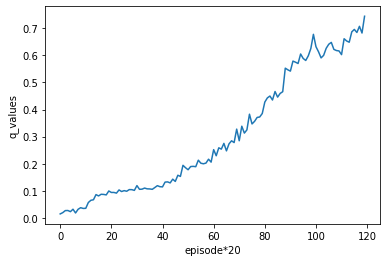

Game 2401, Score = 9.0,Steps = 449, av_score=6.25
Game 2402, Score = 9.0,Steps = 441, av_score=6.32
Game 2403, Score = 5.0,Steps = 354, av_score=6.34
Game 2404, Score = 7.0,Steps = 393, av_score=6.38
Game 2405, Score = 4.0,Steps = 246, av_score=6.37
Game 2406, Score = 3.0,Steps = 238, av_score=6.36
Game 2407, Score = 6.0,Steps = 360, av_score=6.37
Game 2408, Score = 5.0,Steps = 331, av_score=6.31
Game 2409, Score = 8.0,Steps = 484, av_score=6.36
Game 2410, Score = 12.0,Steps = 488, av_score=6.43
Game 2411, Score = 13.0,Steps = 569, av_score=6.52
Game 2412, Score = 8.0,Steps = 426, av_score=6.57
Game 2413, Score = 8.0,Steps = 400, av_score=6.59
Game 2414, Score = 9.0,Steps = 488, av_score=6.64
Game 2415, Score = 8.0,Steps = 307, av_score=6.66
Game 2416, Score = 7.0,Steps = 267, av_score=6.69
Game 2417, Score = 8.0,Steps = 307, av_score=6.74
Game 2418, Score = 7.0,Steps = 405, av_score=6.79
Game 2419, Score = 3.0,Steps = 253, av_score=6.79
Game 2420, Score = 8.0,Steps = 444, av_score=6.7

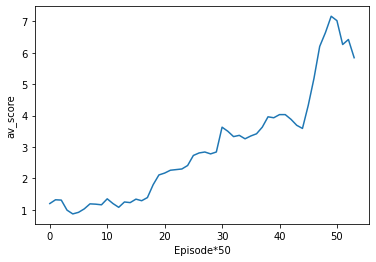

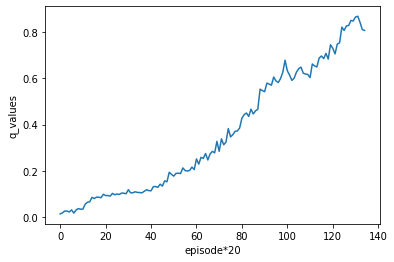

Game 2701, Score = 3.0,Steps = 232, av_score=5.81
Game 2702, Score = 6.0,Steps = 340, av_score=5.85
Game 2703, Score = 3.0,Steps = 228, av_score=5.81
Game 2704, Score = 6.0,Steps = 342, av_score=5.82
Game 2705, Score = 20.0,Steps = 671, av_score=5.92
Game 2706, Score = 3.0,Steps = 212, av_score=5.9
Game 2707, Score = 6.0,Steps = 339, av_score=5.88
Game 2708, Score = 6.0,Steps = 327, av_score=5.89
Game 2709, Score = 3.0,Steps = 234, av_score=5.85
Game 2710, Score = 3.0,Steps = 238, av_score=5.81
Game 2711, Score = 9.0,Steps = 475, av_score=5.84
Game 2712, Score = 3.0,Steps = 223, av_score=5.82
Game 2713, Score = 6.0,Steps = 341, av_score=5.84
Game 2714, Score = 8.0,Steps = 298, av_score=5.79
Game 2715, Score = 8.0,Steps = 407, av_score=5.8
Game 2716, Score = 9.0,Steps = 330, av_score=5.85
Game 2717, Score = 7.0,Steps = 252, av_score=5.83
Game 2718, Score = 2.0,Steps = 184, av_score=5.82
Game 2719, Score = 9.0,Steps = 487, av_score=5.78
Game 2720, Score = 5.0,Steps = 278, av_score=5.75
G

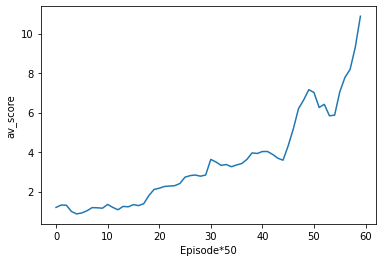

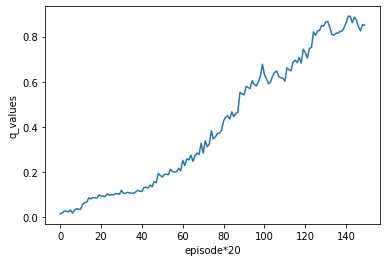

Game 3001, Score = 3.0,Steps = 214, av_score=10.84
Game 3002, Score = 21.0,Steps = 436, av_score=10.97
Game 3003, Score = 5.0,Steps = 277, av_score=10.99
Game 3004, Score = 16.0,Steps = 562, av_score=11.07
Game 3005, Score = 12.0,Steps = 469, av_score=11.07
Game 3006, Score = 4.0,Steps = 278, av_score=10.96
Game 3007, Score = 8.0,Steps = 428, av_score=10.85
Game 3008, Score = 19.0,Steps = 443, av_score=10.97
Game 3009, Score = 25.0,Steps = 665, av_score=11.1
Game 3010, Score = 4.0,Steps = 275, av_score=11.09
Game 3011, Score = 18.0,Steps = 426, av_score=11.22
Game 3012, Score = 13.0,Steps = 467, av_score=11.13
Game 3013, Score = 10.0,Steps = 522, av_score=11.12
Game 3014, Score = 3.0,Steps = 227, av_score=11.06
Game 3015, Score = 14.0,Steps = 530, av_score=11.11
Game 3016, Score = 13.0,Steps = 348, av_score=11.21
Game 3017, Score = 20.0,Steps = 476, av_score=11.32
Game 3018, Score = 8.0,Steps = 443, av_score=11.33
Game 3019, Score = 13.0,Steps = 527, av_score=11.34
Game 3020, Score = 1

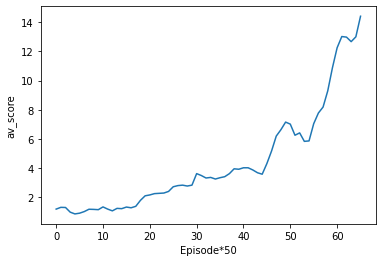

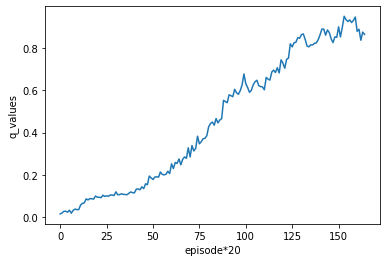

Game 3301, Score = 21.0,Steps = 648, av_score=14.51
Game 3302, Score = 12.0,Steps = 422, av_score=14.51
Game 3303, Score = 9.0,Steps = 425, av_score=14.52
Game 3304, Score = 19.0,Steps = 588, av_score=14.52
Game 3305, Score = 14.0,Steps = 476, av_score=14.54
Game 3306, Score = 14.0,Steps = 412, av_score=14.64
Game 3307, Score = 13.0,Steps = 367, av_score=14.69
Game 3308, Score = 13.0,Steps = 368, av_score=14.69
Game 3309, Score = 9.0,Steps = 328, av_score=14.54
Game 3310, Score = 11.0,Steps = 376, av_score=14.47
Game 3311, Score = 8.0,Steps = 274, av_score=14.49
Game 3312, Score = 15.0,Steps = 521, av_score=14.56
Game 3313, Score = 11.0,Steps = 501, av_score=14.57
Game 3314, Score = 12.0,Steps = 520, av_score=14.57
Game 3315, Score = 22.0,Steps = 679, av_score=14.65
Game 3316, Score = 4.0,Steps = 264, av_score=14.59
Game 3317, Score = 17.0,Steps = 606, av_score=14.56
Game 3318, Score = 16.0,Steps = 482, av_score=14.42
Game 3319, Score = 15.0,Steps = 558, av_score=14.39
Game 3320, Score

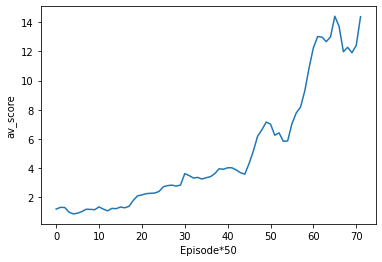

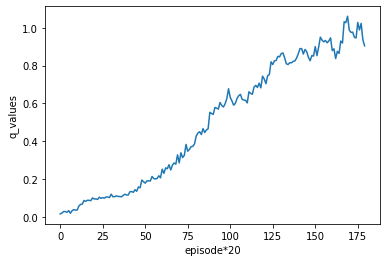

Game 3601, Score = 11.0,Steps = 390, av_score=14.4
Game 3602, Score = 18.0,Steps = 555, av_score=14.49
Game 3603, Score = 19.0,Steps = 557, av_score=14.6
Game 3604, Score = 18.0,Steps = 575, av_score=14.69
Game 3605, Score = 21.0,Steps = 719, av_score=14.63
Game 3606, Score = 20.0,Steps = 520, av_score=14.71
Game 3607, Score = 14.0,Steps = 507, av_score=14.6
Game 3608, Score = 13.0,Steps = 448, av_score=14.5
Game 3609, Score = 18.0,Steps = 570, av_score=14.54
Game 3610, Score = 14.0,Steps = 492, av_score=14.54
Game 3611, Score = 27.0,Steps = 689, av_score=14.7
Game 3612, Score = 9.0,Steps = 448, av_score=14.74
Game 3613, Score = 20.0,Steps = 441, av_score=14.7
Game 3614, Score = 9.0,Steps = 530, av_score=14.68
Game 3615, Score = 25.0,Steps = 813, av_score=14.83
Game 3616, Score = 35.0,Steps = 951, av_score=15.13
Game 3617, Score = 19.0,Steps = 520, av_score=15.18
Game 3618, Score = 28.0,Steps = 521, av_score=15.3
Game 3619, Score = 16.0,Steps = 474, av_score=15.3
Game 3620, Score = 16.

KeyboardInterrupt: ignored

In [ ]:
agent=agent()
summary(agent.model,(1,512))
test_states=load_tests()
scores=deque(maxlen=100)
i=0
s=[]
p=[]

for n in range(0,n_ep):
    h=0
    
    score=0
    state=np.zeros((1,3*128))
    obs=env.reset()
    obs=obs.reshape(1,128)
    state=np.concatenate((state,obs/255),axis=1)
    done=False
    li=5
    while True:
        if(i<50000):
          eps=1
        elif(i<1050000):
          eps-=0.9/1000000
        elif(i<2050000):
          eps-=0.05/1000000
        action= agent.action( state, eps)
        next_obs,reward,done,_=env.step(action)
        lf=env.ale.lives()
        score+=reward
        next_obs=next_obs.reshape(1,128)
        if(li==lf):
            next_state=state[:,128:].copy()
            next_state=np.concatenate([next_state,next_obs/255.0], axis = 1)
            agent.remember(state,action,reward,next_state,done)
        else:
            li=lf
            next_state=np.zeros((1,3*128))
            next_state=np.concatenate([next_state,next_obs/255.0], axis = 1)
            agent.remember(state,action,reward,next_state,1)
        
        i+=1

        state=next_state.copy()
        h+=1
        if((i+1)>batch_size):
            agent.train()
        if done:
            break

    if((n+1)%20==0):
        with torch.no_grad():
            v=(torch.max(agent.model(test_states),1,keepdim=True)).values
        p.append(v.mean())

    scores.append(score)
    avg_reward = np.mean(scores)
    print('Game {}, Score = {},Steps = {}, av_score={}'.format(n+1,score,h,avg_reward))
    if((n+1)%50==0):
        s.append(avg_reward)
    if((n+1)%300==0): 
        print(i,eps)
        if((n+1)%600==0):
            save_model()
        else:
            save_model2()
        plotter(s,p)   

In [ ]:
def save_agent():
        model_save_name = 'breakout_agent2.pt'
        path = F"/content/gdrive/My Drive/{model_save_name}" 
        checkpoint = {
                        'n':n,
                        'i':i,
                        'eps': eps,
                        's':s,
                        'p':p,
                        'av':scores
                        }

        torch.save(checkpoint, path)


In [ ]:
def load_agent():
        model_save_name = 'breakout_agent.pt'
        path = F"/content/gdrive/My Drive/{model_save_name}" 
        checkpoint=torch.load(path)
        n=checkpoint['n']
        print(n)
        i=checkpoint['i']
        s=checkpoint['s']
        p=checkpoint['p']
        scores=checkpoint['av']
        eps=checkpoint['eps']


In [ ]:
agent=agent()
load_model()

11734
11735 7732765 [tensor(0.0148), tensor(0.0195), tensor(0.0270), tensor(0.0274), tensor(0.0232), tensor(0.0321), tensor(0.0183), tensor(0.0319), tensor(0.0377), tensor(0.0350), tensor(0.0355), tensor(0.0568), tensor(0.0651), tensor(0.0670), tensor(0.0860), tensor(0.0811), tensor(0.0872), tensor(0.0867), tensor(0.0850), tensor(0.0994), tensor(0.0940), tensor(0.0940), tensor(0.0915), tensor(0.1033), tensor(0.0974), tensor(0.1007), tensor(0.0984), tensor(0.1045), tensor(0.1043), tensor(0.1016), tensor(0.1193), tensor(0.1055), tensor(0.1061), tensor(0.1101), tensor(0.1073), tensor(0.1069), tensor(0.1056), tensor(0.1121), tensor(0.1190), tensor(0.1152), tensor(0.1145), tensor(0.1322), tensor(0.1329), tensor(0.1292), tensor(0.1430), tensor(0.1346), tensor(0.1575), tensor(0.1531), tensor(0.1942), tensor(0.1852), tensor(0.1777), tensor(0.1895), tensor(0.1903), tensor(0.1890), tensor(0.2131), tensor(0.2018), tensor(0.1998), tensor(0.2024), tensor(0.2166), tensor(0.2059), tensor(0.2519), ten

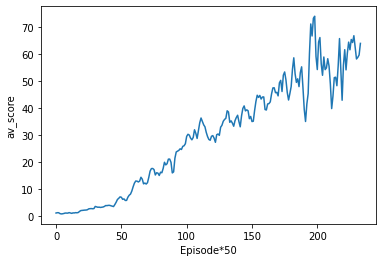

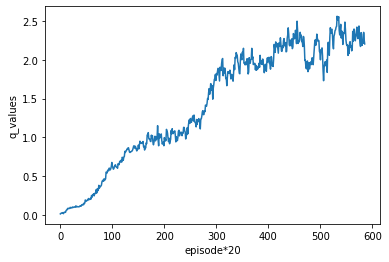

0.05


In [ ]:

model_save_name = 'breakout_agent2.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
checkpoint=torch.load(path)
n=checkpoint['n']
print(n)
i=checkpoint['i']
s=checkpoint['s']
p=checkpoint['p']
scores=checkpoint['av']
eps=checkpoint['eps']
test_states=load_tests()
print(n+1,i,p)
x=n+1
plotter(s,p)
print(eps)

Game 3892, Score = 31.0,Steps = 866, av_score=15.8
Game 3893, Score = 14.0,Steps = 513, av_score=15.8
Game 3894, Score = 11.0,Steps = 527, av_score=15.7
Game 3895, Score = 17.0,Steps = 794, av_score=15.72
Game 3896, Score = 16.0,Steps = 592, av_score=15.82
Game 3897, Score = 10.0,Steps = 476, av_score=15.74
Game 3898, Score = 21.0,Steps = 609, av_score=15.89
Game 3899, Score = 8.0,Steps = 429, av_score=15.89
Game 3900, Score = 28.0,Steps = 565, av_score=16.08
1199360 0.09253200000937059


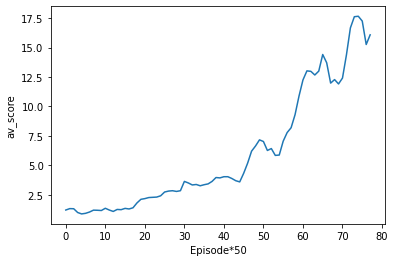

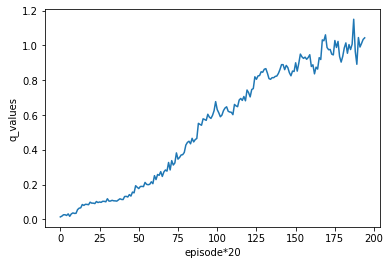

Game 3901, Score = 8.0,Steps = 402, av_score=15.81
Game 3902, Score = 12.0,Steps = 449, av_score=15.82
Game 3903, Score = 10.0,Steps = 516, av_score=15.78
Game 3904, Score = 10.0,Steps = 490, av_score=15.7
Game 3905, Score = 18.0,Steps = 643, av_score=15.66
Game 3906, Score = 11.0,Steps = 492, av_score=15.69
Game 3907, Score = 20.0,Steps = 720, av_score=15.81
Game 3908, Score = 4.0,Steps = 276, av_score=15.71
Game 3909, Score = 19.0,Steps = 798, av_score=15.79
Game 3910, Score = 8.0,Steps = 429, av_score=15.81
Game 3911, Score = 15.0,Steps = 489, av_score=15.86
Game 3912, Score = 13.0,Steps = 437, av_score=15.92
Game 3913, Score = 7.0,Steps = 389, av_score=15.92
Game 3914, Score = 22.0,Steps = 588, av_score=16.03
Game 3915, Score = 6.0,Steps = 327, av_score=16.02
Game 3916, Score = 18.0,Steps = 670, av_score=16.05
Game 3917, Score = 16.0,Steps = 463, av_score=15.98
Game 3918, Score = 12.0,Steps = 547, av_score=16.03
Game 3919, Score = 22.0,Steps = 625, av_score=16.11
Game 3920, Score =

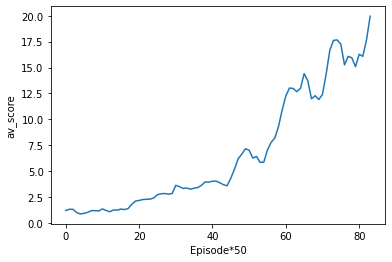

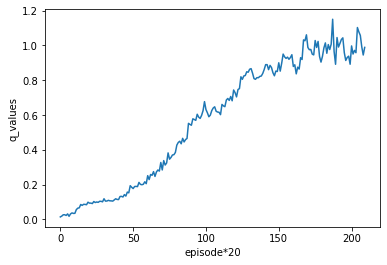

Game 4201, Score = 19.0,Steps = 651, av_score=19.78
Game 4202, Score = 29.0,Steps = 608, av_score=19.71
Game 4203, Score = 34.0,Steps = 910, av_score=19.93
Game 4204, Score = 17.0,Steps = 596, av_score=19.95
Game 4205, Score = 12.0,Steps = 540, av_score=19.93
Game 4206, Score = 16.0,Steps = 722, av_score=19.81
Game 4207, Score = 38.0,Steps = 813, av_score=20.04
Game 4208, Score = 17.0,Steps = 681, av_score=20.11
Game 4209, Score = 20.0,Steps = 609, av_score=20.0
Game 4210, Score = 14.0,Steps = 473, av_score=20.03
Game 4211, Score = 20.0,Steps = 638, av_score=20.11
Game 4212, Score = 18.0,Steps = 507, av_score=19.97
Game 4213, Score = 12.0,Steps = 548, av_score=20.02
Game 4214, Score = 18.0,Steps = 762, av_score=19.98
Game 4215, Score = 10.0,Steps = 466, av_score=19.95
Game 4216, Score = 8.0,Steps = 383, av_score=19.87
Game 4217, Score = 16.0,Steps = 537, av_score=19.69
Game 4218, Score = 31.0,Steps = 579, av_score=19.72
Game 4219, Score = 34.0,Steps = 700, av_score=20.01
Game 4220, Sco

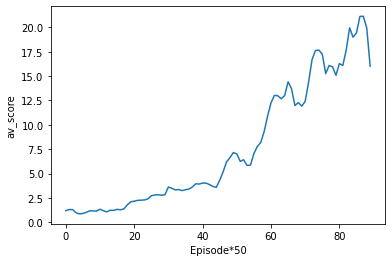

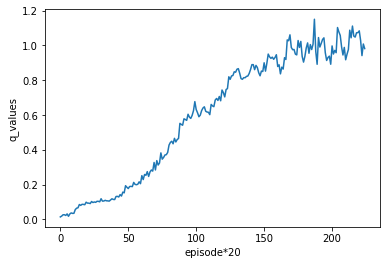

Game 4501, Score = 16.0,Steps = 555, av_score=16.01
Game 4502, Score = 39.0,Steps = 763, av_score=16.25
Game 4503, Score = 12.0,Steps = 554, av_score=16.08
Game 4504, Score = 12.0,Steps = 520, av_score=15.92
Game 4505, Score = 16.0,Steps = 745, av_score=15.93
Game 4506, Score = 27.0,Steps = 703, av_score=16.06
Game 4507, Score = 15.0,Steps = 791, av_score=16.09
Game 4508, Score = 18.0,Steps = 630, av_score=16.13
Game 4509, Score = 18.0,Steps = 622, av_score=16.23
Game 4510, Score = 20.0,Steps = 782, av_score=16.14
Game 4511, Score = 19.0,Steps = 708, av_score=15.92
Game 4512, Score = 17.0,Steps = 758, av_score=15.98
Game 4513, Score = 13.0,Steps = 579, av_score=15.97
Game 4514, Score = 16.0,Steps = 544, av_score=15.94
Game 4515, Score = 19.0,Steps = 586, av_score=15.99
Game 4516, Score = 9.0,Steps = 542, av_score=15.97
Game 4517, Score = 21.0,Steps = 767, av_score=15.9
Game 4518, Score = 24.0,Steps = 915, av_score=15.93
Game 4519, Score = 27.0,Steps = 830, av_score=15.9
Game 4520, Scor

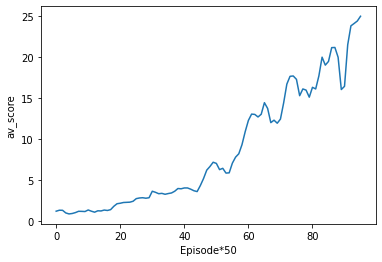

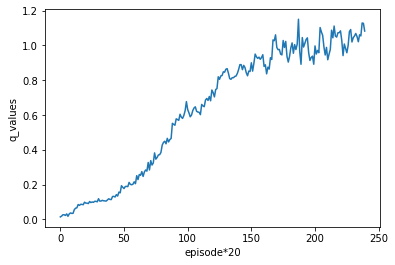

Game 4801, Score = 29.0,Steps = 610, av_score=25.01
Game 4802, Score = 23.0,Steps = 813, av_score=24.95
Game 4803, Score = 41.0,Steps = 922, av_score=25.21
Game 4804, Score = 29.0,Steps = 510, av_score=25.24
Game 4805, Score = 23.0,Steps = 744, av_score=25.16
Game 4806, Score = 22.0,Steps = 653, av_score=25.24
Game 4807, Score = 41.0,Steps = 1125, av_score=25.51
Game 4808, Score = 38.0,Steps = 1134, av_score=25.72
Game 4809, Score = 31.0,Steps = 962, av_score=25.86
Game 4810, Score = 39.0,Steps = 844, av_score=26.05
Game 4811, Score = 36.0,Steps = 775, av_score=26.1
Game 4812, Score = 27.0,Steps = 793, av_score=26.22
Game 4813, Score = 29.0,Steps = 1084, av_score=26.28
Game 4814, Score = 37.0,Steps = 1059, av_score=26.37
Game 4815, Score = 17.0,Steps = 678, av_score=26.31
Game 4816, Score = 21.0,Steps = 718, av_score=26.19
Game 4817, Score = 25.0,Steps = 715, av_score=26.27
Game 4818, Score = 30.0,Steps = 721, av_score=26.33
Game 4819, Score = 32.0,Steps = 534, av_score=26.39
Game 4820

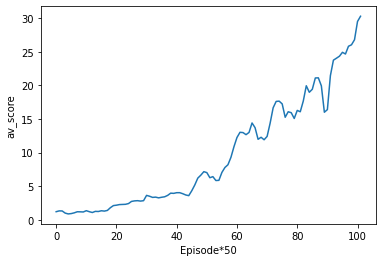

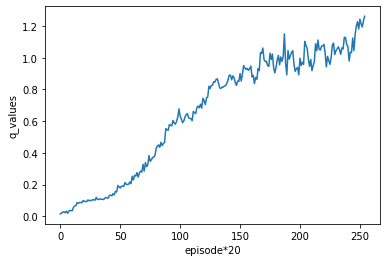

Game 5101, Score = 26.0,Steps = 569, av_score=30.31
Game 5102, Score = 21.0,Steps = 793, av_score=30.22
Game 5103, Score = 27.0,Steps = 1002, av_score=30.35
Game 5104, Score = 24.0,Steps = 691, av_score=30.22
Game 5105, Score = 14.0,Steps = 504, av_score=30.14
Game 5106, Score = 31.0,Steps = 923, av_score=30.21
Game 5107, Score = 22.0,Steps = 657, av_score=30.17
Game 5108, Score = 37.0,Steps = 951, av_score=30.28
Game 5109, Score = 18.0,Steps = 645, av_score=30.05
Game 5110, Score = 31.0,Steps = 606, av_score=30.21
Game 5111, Score = 29.0,Steps = 931, av_score=30.07
Game 5112, Score = 47.0,Steps = 887, av_score=30.21
Game 5113, Score = 43.0,Steps = 1256, av_score=30.52
Game 5114, Score = 9.0,Steps = 433, av_score=30.24
Game 5115, Score = 37.0,Steps = 855, av_score=30.38
Game 5116, Score = 54.0,Steps = 918, av_score=30.59
Game 5117, Score = 39.0,Steps = 804, av_score=30.64
Game 5118, Score = 37.0,Steps = 822, av_score=30.74
Game 5119, Score = 29.0,Steps = 787, av_score=30.5
Game 5120, S

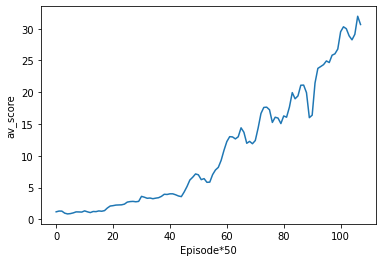

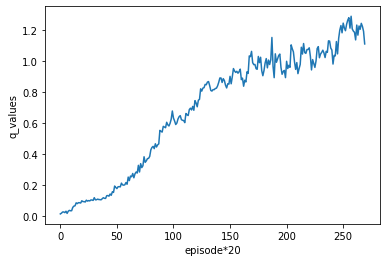

Game 5401, Score = 24.0,Steps = 702, av_score=30.45
Game 5402, Score = 19.0,Steps = 752, av_score=30.12
Game 5403, Score = 44.0,Steps = 817, av_score=30.03
Game 5404, Score = 40.0,Steps = 788, av_score=30.13
Game 5405, Score = 36.0,Steps = 863, av_score=30.18
Game 5406, Score = 18.0,Steps = 703, av_score=29.86
Game 5407, Score = 29.0,Steps = 821, av_score=29.94
Game 5408, Score = 46.0,Steps = 863, av_score=29.9
Game 5409, Score = 39.0,Steps = 846, av_score=29.9
Game 5410, Score = 40.0,Steps = 900, av_score=30.0
Game 5411, Score = 28.0,Steps = 606, av_score=30.04
Game 5412, Score = 13.0,Steps = 604, av_score=29.8
Game 5413, Score = 42.0,Steps = 933, av_score=30.03
Game 5414, Score = 27.0,Steps = 712, av_score=29.88
Game 5415, Score = 13.0,Steps = 479, av_score=29.93
Game 5416, Score = 44.0,Steps = 988, av_score=30.14
Game 5417, Score = 35.0,Steps = 778, av_score=30.06
Game 5418, Score = 21.0,Steps = 614, av_score=30.0
Game 5419, Score = 18.0,Steps = 635, av_score=29.93
Game 5420, Score 

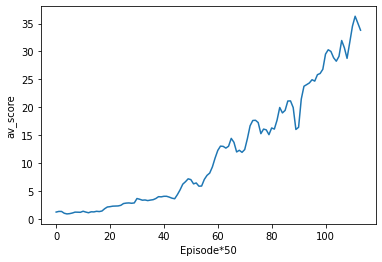

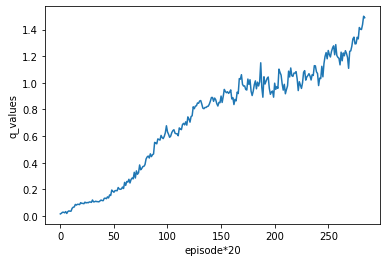

Game 5701, Score = 28.0,Steps = 623, av_score=33.75
Game 5702, Score = 31.0,Steps = 570, av_score=33.66
Game 5703, Score = 37.0,Steps = 969, av_score=33.69
Game 5704, Score = 31.0,Steps = 845, av_score=33.77
Game 5705, Score = 29.0,Steps = 806, av_score=33.72
Game 5706, Score = 47.0,Steps = 1003, av_score=33.88
Game 5707, Score = 37.0,Steps = 907, av_score=33.97
Game 5708, Score = 39.0,Steps = 1166, av_score=33.92
Game 5709, Score = 47.0,Steps = 734, av_score=33.7
Game 5710, Score = 33.0,Steps = 804, av_score=33.71
Game 5711, Score = 29.0,Steps = 897, av_score=33.61
Game 5712, Score = 27.0,Steps = 463, av_score=33.52
Game 5713, Score = 26.0,Steps = 827, av_score=33.34
Game 5714, Score = 50.0,Steps = 1216, av_score=33.5
Game 5715, Score = 20.0,Steps = 612, av_score=33.3
Game 5716, Score = 25.0,Steps = 925, av_score=33.02
Game 5717, Score = 32.0,Steps = 848, av_score=33.22
Game 5718, Score = 27.0,Steps = 802, av_score=33.12
Game 5719, Score = 36.0,Steps = 933, av_score=33.31
Game 5720, S

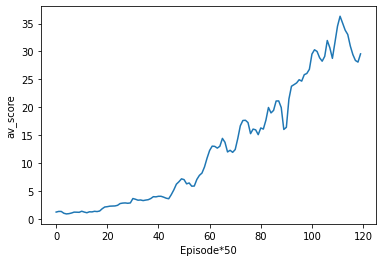

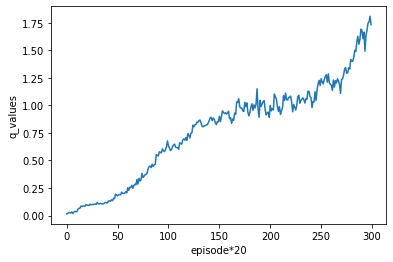

Game 6001, Score = 27.0,Steps = 900, av_score=29.67
Game 6002, Score = 34.0,Steps = 860, av_score=29.72
Game 6003, Score = 26.0,Steps = 792, av_score=29.59
Game 6004, Score = 37.0,Steps = 941, av_score=29.69
Game 6005, Score = 22.0,Steps = 761, av_score=29.48
Game 6006, Score = 24.0,Steps = 855, av_score=29.37
Game 6007, Score = 31.0,Steps = 751, av_score=29.25
Game 6008, Score = 47.0,Steps = 1173, av_score=29.34
Game 6009, Score = 19.0,Steps = 713, av_score=29.26
Game 6010, Score = 28.0,Steps = 818, av_score=29.15
Game 6011, Score = 39.0,Steps = 1083, av_score=29.22
Game 6012, Score = 18.0,Steps = 622, av_score=29.18
Game 6013, Score = 26.0,Steps = 645, av_score=29.11
Game 6014, Score = 31.0,Steps = 1025, av_score=29.3
Game 6015, Score = 27.0,Steps = 850, av_score=29.29
Game 6016, Score = 19.0,Steps = 565, av_score=29.21
Game 6017, Score = 33.0,Steps = 966, av_score=29.19
Game 6018, Score = 26.0,Steps = 830, av_score=29.23
Game 6019, Score = 39.0,Steps = 1025, av_score=29.27
Game 6020

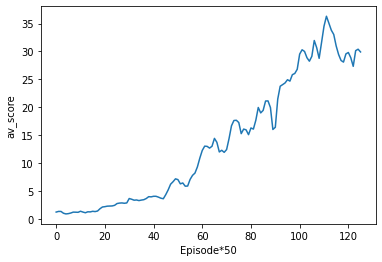

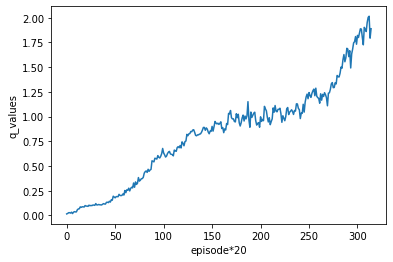

Game 6301, Score = 50.0,Steps = 1128, av_score=30.12
Game 6302, Score = 17.0,Steps = 622, av_score=30.09
Game 6303, Score = 45.0,Steps = 687, av_score=30.4
Game 6304, Score = 35.0,Steps = 879, av_score=30.49
Game 6305, Score = 19.0,Steps = 736, av_score=30.42
Game 6306, Score = 41.0,Steps = 922, av_score=30.54
Game 6307, Score = 43.0,Steps = 888, av_score=30.7
Game 6308, Score = 32.0,Steps = 869, av_score=30.78
Game 6309, Score = 35.0,Steps = 909, av_score=30.87
Game 6310, Score = 63.0,Steps = 957, av_score=31.25
Game 6311, Score = 41.0,Steps = 773, av_score=31.4
Game 6312, Score = 26.0,Steps = 563, av_score=31.28
Game 6313, Score = 11.0,Steps = 365, av_score=31.17
Game 6314, Score = 25.0,Steps = 713, av_score=31.1
Game 6315, Score = 32.0,Steps = 777, av_score=31.09
Game 6316, Score = 36.0,Steps = 769, av_score=31.1
Game 6317, Score = 26.0,Steps = 772, av_score=31.19
Game 6318, Score = 38.0,Steps = 991, av_score=31.21
Game 6319, Score = 26.0,Steps = 585, av_score=31.36
Game 6320, Score

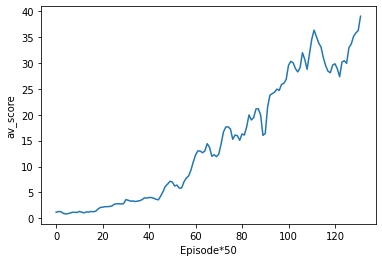

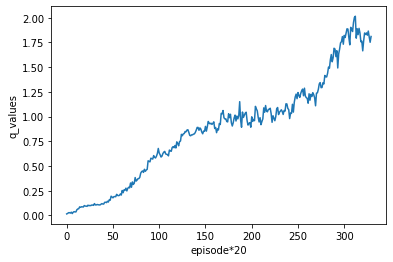

Game 6601, Score = 28.0,Steps = 934, av_score=38.94
Game 6602, Score = 25.0,Steps = 718, av_score=38.6
Game 6603, Score = 35.0,Steps = 898, av_score=38.69
Game 6604, Score = 36.0,Steps = 1183, av_score=38.72
Game 6605, Score = 22.0,Steps = 786, av_score=38.8
Game 6606, Score = 23.0,Steps = 840, av_score=38.63
Game 6607, Score = 38.0,Steps = 789, av_score=38.69
Game 6608, Score = 43.0,Steps = 1164, av_score=38.78
Game 6609, Score = 38.0,Steps = 868, av_score=38.71
Game 6610, Score = 32.0,Steps = 1047, av_score=38.61
Game 6611, Score = 32.0,Steps = 881, av_score=38.62
Game 6612, Score = 44.0,Steps = 985, av_score=38.8
Game 6613, Score = 42.0,Steps = 955, av_score=38.99
Game 6614, Score = 58.0,Steps = 1191, av_score=39.22
Game 6615, Score = 31.0,Steps = 871, av_score=39.21
Game 6616, Score = 26.0,Steps = 847, av_score=38.89
Game 6617, Score = 44.0,Steps = 923, av_score=39.0
Game 6618, Score = 33.0,Steps = 993, av_score=38.96
Game 6619, Score = 39.0,Steps = 1199, av_score=38.91
Game 6620, 

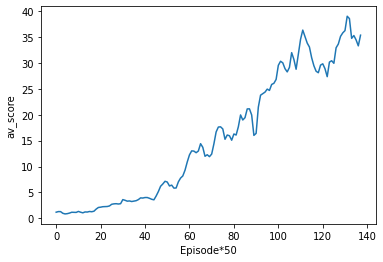

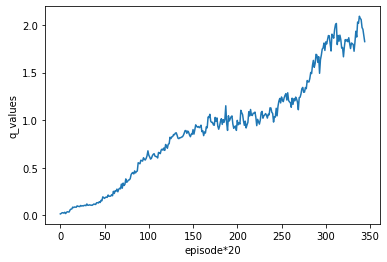

Game 6901, Score = 24.0,Steps = 852, av_score=35.13
Game 6902, Score = 84.0,Steps = 941, av_score=35.72
Game 6903, Score = 35.0,Steps = 771, av_score=35.7
Game 6904, Score = 59.0,Steps = 984, av_score=35.76
Game 6905, Score = 51.0,Steps = 1033, av_score=35.98
Game 6906, Score = 52.0,Steps = 1192, av_score=36.19
Game 6907, Score = 31.0,Steps = 907, av_score=36.18
Game 6908, Score = 54.0,Steps = 766, av_score=36.54
Game 6909, Score = 35.0,Steps = 1082, av_score=36.62
Game 6910, Score = 37.0,Steps = 997, av_score=36.52
Game 6911, Score = 46.0,Steps = 850, av_score=36.65
Game 6912, Score = 30.0,Steps = 686, av_score=36.59
Game 6913, Score = 48.0,Steps = 987, av_score=36.76
Game 6914, Score = 30.0,Steps = 827, av_score=36.8
Game 6915, Score = 46.0,Steps = 982, av_score=36.83
Game 6916, Score = 30.0,Steps = 803, av_score=36.69
Game 6917, Score = 33.0,Steps = 769, av_score=36.67
Game 6918, Score = 31.0,Steps = 796, av_score=36.17
Game 6919, Score = 21.0,Steps = 787, av_score=35.88
Game 6920, 

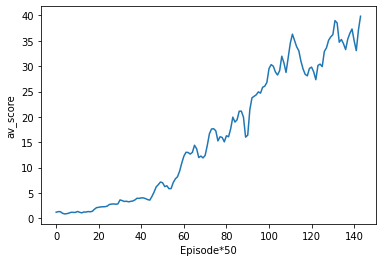

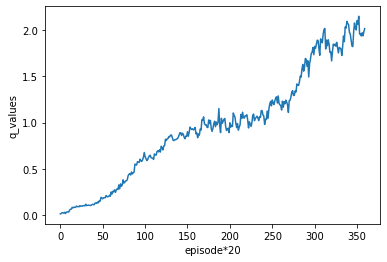

Game 7201, Score = 49.0,Steps = 1187, av_score=40.23
Game 7202, Score = 37.0,Steps = 746, av_score=40.23
Game 7203, Score = 48.0,Steps = 1042, av_score=40.44
Game 7204, Score = 49.0,Steps = 1050, av_score=40.57
Game 7205, Score = 53.0,Steps = 1265, av_score=40.78
Game 7206, Score = 25.0,Steps = 691, av_score=40.72
Game 7207, Score = 38.0,Steps = 995, av_score=40.77
Game 7208, Score = 62.0,Steps = 666, av_score=41.16
Game 7209, Score = 30.0,Steps = 911, av_score=41.05
Game 7210, Score = 65.0,Steps = 837, av_score=41.38
Game 7211, Score = 34.0,Steps = 969, av_score=41.55
Game 7212, Score = 20.0,Steps = 518, av_score=41.49
Game 7213, Score = 67.0,Steps = 1083, av_score=40.46
Game 7214, Score = 47.0,Steps = 830, av_score=40.47
Game 7215, Score = 24.0,Steps = 884, av_score=40.43
Game 7216, Score = 51.0,Steps = 952, av_score=40.59
Game 7217, Score = 34.0,Steps = 758, av_score=39.68
Game 7218, Score = 62.0,Steps = 789, av_score=40.07
Game 7219, Score = 48.0,Steps = 1276, av_score=39.93
Game 7

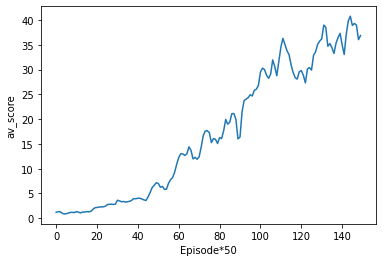

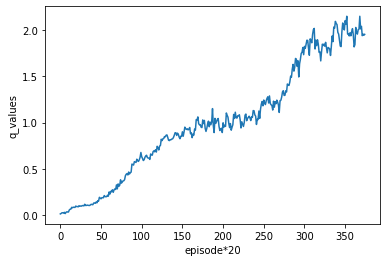

Game 7501, Score = 17.0,Steps = 584, av_score=36.78
Game 7502, Score = 27.0,Steps = 840, av_score=36.66
Game 7503, Score = 42.0,Steps = 993, av_score=36.8
Game 7504, Score = 31.0,Steps = 818, av_score=36.63
Game 7505, Score = 25.0,Steps = 796, av_score=36.73
Game 7506, Score = 36.0,Steps = 679, av_score=36.73
Game 7507, Score = 23.0,Steps = 722, av_score=36.64
Game 7508, Score = 51.0,Steps = 895, av_score=36.61
Game 7509, Score = 56.0,Steps = 1071, av_score=36.77
Game 7510, Score = 22.0,Steps = 636, av_score=36.44
Game 7511, Score = 21.0,Steps = 559, av_score=36.26
Game 7512, Score = 39.0,Steps = 999, av_score=36.39
Game 7513, Score = 22.0,Steps = 840, av_score=36.48
Game 7514, Score = 33.0,Steps = 541, av_score=36.4
Game 7515, Score = 26.0,Steps = 707, av_score=36.28
Game 7516, Score = 29.0,Steps = 771, av_score=36.32
Game 7517, Score = 44.0,Steps = 1042, av_score=36.62
Game 7518, Score = 33.0,Steps = 762, av_score=36.5
Game 7519, Score = 26.0,Steps = 752, av_score=35.95
Game 7520, Sc

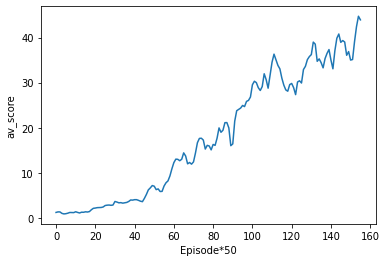

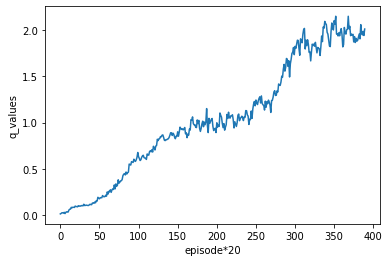

Game 7801, Score = 18.0,Steps = 653, av_score=43.38
Game 7802, Score = 23.0,Steps = 708, av_score=43.2
Game 7803, Score = 32.0,Steps = 1035, av_score=42.9
Game 7804, Score = 40.0,Steps = 1064, av_score=42.86
Game 7805, Score = 25.0,Steps = 602, av_score=42.73
Game 7806, Score = 48.0,Steps = 1033, av_score=42.84
Game 7807, Score = 49.0,Steps = 801, av_score=43.18
Game 7808, Score = 53.0,Steps = 989, av_score=43.42
Game 7809, Score = 44.0,Steps = 805, av_score=43.61
Game 7810, Score = 34.0,Steps = 923, av_score=43.59
Game 7811, Score = 58.0,Steps = 1134, av_score=43.79
Game 7812, Score = 264.0,Steps = 1380, av_score=46.04
Game 7813, Score = 30.0,Steps = 533, av_score=45.78
Game 7814, Score = 41.0,Steps = 1006, av_score=45.85
Game 7815, Score = 52.0,Steps = 1146, av_score=45.97
Game 7816, Score = 51.0,Steps = 1010, av_score=45.94
Game 7817, Score = 45.0,Steps = 809, av_score=46.16
Game 7818, Score = 41.0,Steps = 603, av_score=46.01
Game 7819, Score = 29.0,Steps = 780, av_score=45.94
Game 

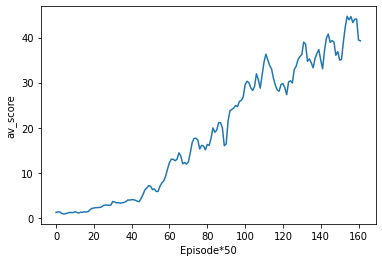

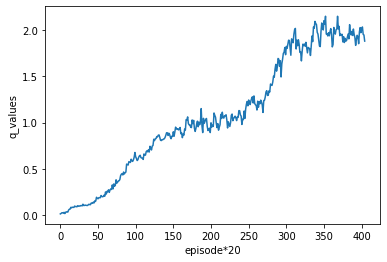

Game 8101, Score = 32.0,Steps = 830, av_score=39.28


KeyboardInterrupt: ignored

In [ ]:



for n in range(x,n_ep):
    h=0
    
    score=0
    state=np.zeros((1,3*128))
    obs=env.reset()
    obs=obs.reshape(1,128)
    state=np.concatenate((state,obs/255),axis=1)
    done=False
    li=5
    while True:
        if(i<50000):
          eps=1
        elif(i<1050000):
          eps-=0.9/1000000
        elif(i<2050000):
          eps-=0.05/1000000
        action= agent.action( state, eps)
        next_obs,reward,done,_=env.step(action)
        lf=env.ale.lives()
        score+=reward
        next_obs=next_obs.reshape(1,128)
        if(li==lf):
            next_state=state[:,128:].copy()
            next_state=np.concatenate([next_state,next_obs/255.0], axis = 1)
            agent.remember(state,action,reward,next_state,done)
        else:
            li=lf
            next_state=np.zeros((1,3*128))
            next_state=np.concatenate([next_state,next_obs/255.0], axis = 1)
            agent.remember(state,action,reward,next_state,1)
        
        i+=1

        state=next_state.copy()
        h+=1
        if((i+1)>batch_size):
            agent.train()
        if done:
            break

    if((n+1)%20==0):
        with torch.no_grad():
            v=(torch.max(agent.model(test_states),1,keepdim=True)).values
        p.append(v.mean())

    scores.append(score)
    avg_reward = np.mean(scores)
    print('Game {}, Score = {},Steps = {}, av_score={}'.format(n+1,score,h,avg_reward))
    if((n+1)%50==0):
        s.append(avg_reward)
    if((n+1)%300==0): 
        print(i,eps)
        if((n+1)%600==0):
            save_model()
            save_agent()
        else:
            save_model2()
            save_agent()
        plotter(s,p)    

Game 8101, Score = 13.0,Steps = 582, av_score=39.09
Game 8102, Score = 53.0,Steps = 815, av_score=39.32
Game 8103, Score = 53.0,Steps = 1107, av_score=39.56
Game 8104, Score = 23.0,Steps = 680, av_score=39.3
Game 8105, Score = 34.0,Steps = 848, av_score=39.3
Game 8106, Score = 50.0,Steps = 727, av_score=39.47
Game 8107, Score = 38.0,Steps = 672, av_score=39.62
Game 8108, Score = 46.0,Steps = 699, av_score=39.65
Game 8109, Score = 28.0,Steps = 606, av_score=39.76
Game 8110, Score = 59.0,Steps = 1074, av_score=39.93
Game 8111, Score = 50.0,Steps = 711, av_score=40.15
Game 8112, Score = 46.0,Steps = 948, av_score=40.19
Game 8113, Score = 27.0,Steps = 661, av_score=39.74
Game 8114, Score = 15.0,Steps = 643, av_score=39.67
Game 8115, Score = 34.0,Steps = 541, av_score=39.64
Game 8116, Score = 36.0,Steps = 741, av_score=39.6
Game 8117, Score = 51.0,Steps = 987, av_score=39.79
Game 8118, Score = 36.0,Steps = 728, av_score=39.78
Game 8119, Score = 33.0,Steps = 932, av_score=39.95
Game 8120, Sc

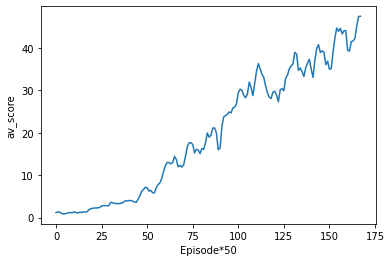

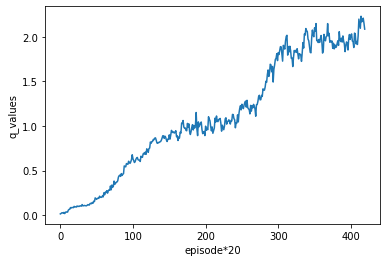

Game 8401, Score = 23.0,Steps = 507, av_score=47.3
Game 8402, Score = 73.0,Steps = 1073, av_score=47.68
Game 8403, Score = 30.0,Steps = 687, av_score=47.85
Game 8404, Score = 43.0,Steps = 1040, av_score=47.23
Game 8405, Score = 49.0,Steps = 802, av_score=47.07
Game 8406, Score = 56.0,Steps = 949, av_score=47.25
Game 8407, Score = 41.0,Steps = 966, av_score=47.08
Game 8408, Score = 44.0,Steps = 855, av_score=47.04
Game 8409, Score = 47.0,Steps = 822, av_score=47.29
Game 8410, Score = 49.0,Steps = 1006, av_score=47.08
Game 8411, Score = 28.0,Steps = 624, av_score=47.05
Game 8412, Score = 54.0,Steps = 1013, av_score=47.02
Game 8413, Score = 30.0,Steps = 757, av_score=47.25
Game 8414, Score = 29.0,Steps = 603, av_score=47.39
Game 8415, Score = 39.0,Steps = 679, av_score=47.56
Game 8416, Score = 47.0,Steps = 1001, av_score=47.73
Game 8417, Score = 38.0,Steps = 588, av_score=47.64
Game 8418, Score = 52.0,Steps = 1118, av_score=47.46
Game 8419, Score = 61.0,Steps = 1083, av_score=47.6
Game 84

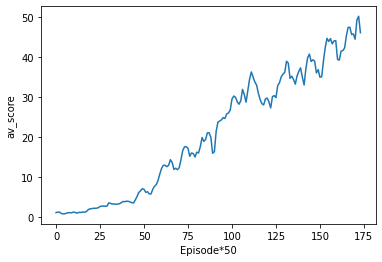

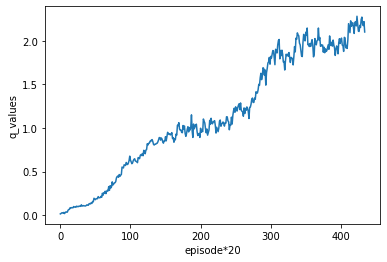

Game 8701, Score = 61.0,Steps = 859, av_score=46.2
Game 8702, Score = 39.0,Steps = 1141, av_score=46.18
Game 8703, Score = 27.0,Steps = 520, av_score=46.21
Game 8704, Score = 27.0,Steps = 667, av_score=46.18
Game 8705, Score = 37.0,Steps = 821, av_score=46.33
Game 8706, Score = 54.0,Steps = 715, av_score=46.73
Game 8707, Score = 33.0,Steps = 569, av_score=46.96
Game 8708, Score = 45.0,Steps = 674, av_score=46.86
Game 8709, Score = 34.0,Steps = 687, av_score=46.95
Game 8710, Score = 52.0,Steps = 1028, av_score=47.03
Game 8711, Score = 24.0,Steps = 712, av_score=46.67
Game 8712, Score = 58.0,Steps = 748, av_score=46.84
Game 8713, Score = 37.0,Steps = 788, av_score=46.89
Game 8714, Score = 44.0,Steps = 752, av_score=46.87
Game 8715, Score = 44.0,Steps = 876, av_score=46.72
Game 8716, Score = 75.0,Steps = 819, av_score=46.9
Game 8717, Score = 88.0,Steps = 1084, av_score=47.34
Game 8718, Score = 290.0,Steps = 1123, av_score=49.67
Game 8719, Score = 44.0,Steps = 823, av_score=49.4
Game 8720,

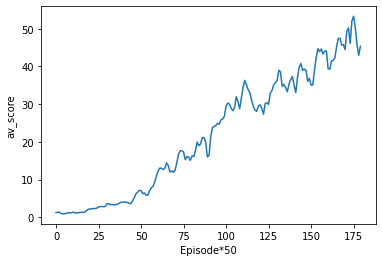

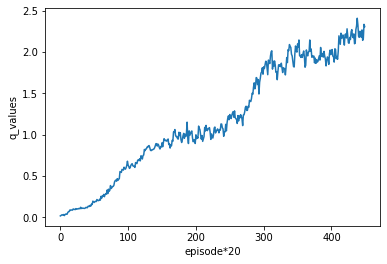

Game 9001, Score = 46.0,Steps = 854, av_score=45.06
Game 9002, Score = 28.0,Steps = 628, av_score=44.76
Game 9003, Score = 32.0,Steps = 716, av_score=44.59
Game 9004, Score = 61.0,Steps = 658, av_score=44.82
Game 9005, Score = 60.0,Steps = 1061, av_score=45.13
Game 9006, Score = 49.0,Steps = 813, av_score=45.06
Game 9007, Score = 24.0,Steps = 735, av_score=44.93
Game 9008, Score = 39.0,Steps = 927, av_score=44.99
Game 9009, Score = 20.0,Steps = 641, av_score=44.58
Game 9010, Score = 136.0,Steps = 1009, av_score=45.4
Game 9011, Score = 24.0,Steps = 700, av_score=45.37
Game 9012, Score = 46.0,Steps = 843, av_score=45.67
Game 9013, Score = 21.0,Steps = 516, av_score=45.22
Game 9014, Score = 32.0,Steps = 699, av_score=44.72
Game 9015, Score = 26.0,Steps = 739, av_score=44.65
Game 9016, Score = 42.0,Steps = 801, av_score=44.74
Game 9017, Score = 41.0,Steps = 628, av_score=44.57
Game 9018, Score = 64.0,Steps = 976, av_score=44.78
Game 9019, Score = 66.0,Steps = 660, av_score=45.12
Game 9020,

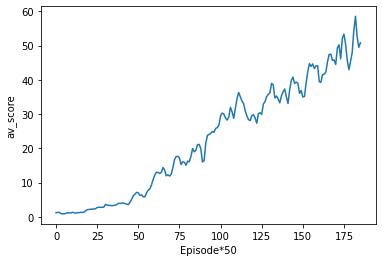

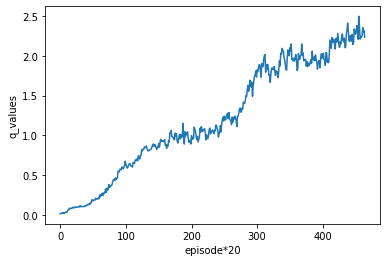

Game 9301, Score = 54.0,Steps = 1054, av_score=50.65


KeyboardInterrupt: ignored

In [ ]:



for n in range(x,n_ep):
    h=0
    score=0
    state=np.zeros((1,3*128))
    obs=env.reset()
    obs=obs.reshape(1,128)
    state=np.concatenate((state,obs/255),axis=1)
    done=False
    li=5
    while True:
        if(i<50000):
          eps=1
        elif(i<1050000):
          eps-=0.9/1000000
        elif(i<2050000):
          eps-=0.05/1000000
        action= agent.action( state, eps)
        next_obs,reward,done,_=env.step(action)
        lf=env.ale.lives()
        score+=reward
        next_obs=next_obs.reshape(1,128)
        if(li==lf):
            next_state=state[:,128:].copy()
            next_state=np.concatenate([next_state,next_obs/255.0], axis = 1)
            agent.remember(state,action,reward,next_state,done)
        else:
            li=lf
            next_state=np.zeros((1,3*128))
            next_state=np.concatenate([next_state,next_obs/255.0], axis = 1)
            agent.remember(state,action,reward,next_state,1)
        i+=1
        state=next_state.copy()
        h+=1
        if((i+1)>batch_size):
            agent.train()
        if done:
            break

    if((n+1)%20==0):
        with torch.no_grad():
            v=(torch.max(agent.model(test_states),1,keepdim=True)).values
        p.append(v.mean())

    scores.append(score)
    avg_reward = np.mean(scores)
    print('Game {}, Score = {},Steps = {}, av_score={}'.format(n+1,score,h,avg_reward))
    if((n+1)%50==0):
        s.append(avg_reward)
    if((n+1)%300==0): 
        print(i,eps)
        if((n+1)%600==0):
            save_model()
            save_agent()
        else:
            save_model2()
            save_agent()
        plotter(s,p)    

Game 9301, Score = 81.0,Steps = 912, av_score=50.92
Game 9302, Score = 53.0,Steps = 1136, av_score=50.49
Game 9303, Score = 64.0,Steps = 1099, av_score=50.86
Game 9304, Score = 28.0,Steps = 881, av_score=50.93
Game 9305, Score = 24.0,Steps = 864, av_score=50.91
Game 9306, Score = 37.0,Steps = 986, av_score=50.95
Game 9307, Score = 73.0,Steps = 950, av_score=51.36
Game 9308, Score = 47.0,Steps = 1321, av_score=51.61
Game 9309, Score = 63.0,Steps = 1265, av_score=51.79
Game 9310, Score = 38.0,Steps = 744, av_score=51.32
Game 9311, Score = 29.0,Steps = 940, av_score=51.08
Game 9312, Score = 61.0,Steps = 1171, av_score=51.37
Game 9313, Score = 102.0,Steps = 1275, av_score=51.18
Game 9314, Score = 23.0,Steps = 830, av_score=51.18
Game 9315, Score = 50.0,Steps = 1045, av_score=51.49
Game 9316, Score = 57.0,Steps = 1120, av_score=51.46
Game 9317, Score = 43.0,Steps = 1243, av_score=51.77
Game 9318, Score = 53.0,Steps = 1288, av_score=51.48
Game 9319, Score = 23.0,Steps = 1013, av_score=51.47


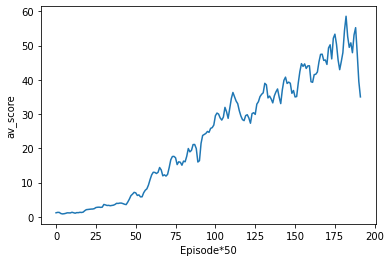

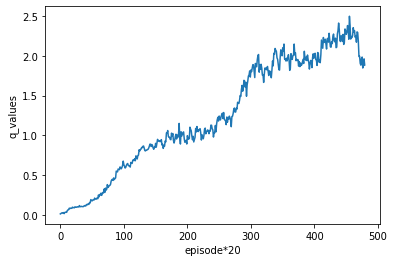

Game 9601, Score = 28.0,Steps = 954, av_score=34.64
Game 9602, Score = 34.0,Steps = 974, av_score=34.37
Game 9603, Score = 48.0,Steps = 1171, av_score=34.5
Game 9604, Score = 35.0,Steps = 906, av_score=34.3
Game 9605, Score = 37.0,Steps = 1097, av_score=34.36
Game 9606, Score = 79.0,Steps = 1073, av_score=34.86
Game 9607, Score = 29.0,Steps = 687, av_score=34.84
Game 9608, Score = 65.0,Steps = 1094, av_score=35.1
Game 9609, Score = 79.0,Steps = 1490, av_score=35.27
Game 9610, Score = 59.0,Steps = 1045, av_score=35.57
Game 9611, Score = 88.0,Steps = 1374, av_score=36.16
Game 9612, Score = 61.0,Steps = 1485, av_score=36.48
Game 9613, Score = 75.0,Steps = 1130, av_score=36.96
Game 9614, Score = 74.0,Steps = 1090, av_score=37.28
Game 9615, Score = 12.0,Steps = 634, av_score=37.08
Game 9616, Score = 37.0,Steps = 1017, av_score=36.65
Game 9617, Score = 28.0,Steps = 1053, av_score=36.41
Game 9618, Score = 58.0,Steps = 982, av_score=36.49
Game 9619, Score = 15.0,Steps = 583, av_score=36.38
Gam

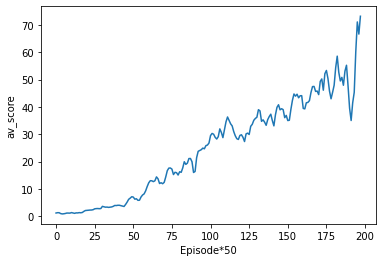

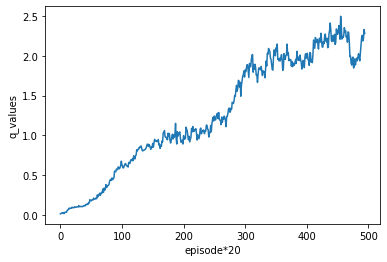

Game 9901, Score = 79.0,Steps = 911, av_score=73.47
Game 9902, Score = 25.0,Steps = 596, av_score=73.27
Game 9903, Score = 36.0,Steps = 675, av_score=73.14
Game 9904, Score = 29.0,Steps = 477, av_score=71.16
Game 9905, Score = 30.0,Steps = 713, av_score=71.15
Game 9906, Score = 28.0,Steps = 512, av_score=69.59
Game 9907, Score = 89.0,Steps = 1041, av_score=70.1
Game 9908, Score = 61.0,Steps = 955, av_score=70.26
Game 9909, Score = 169.0,Steps = 824, av_score=71.31
Game 9910, Score = 28.0,Steps = 695, av_score=71.2
Game 9911, Score = 32.0,Steps = 516, av_score=70.62
Game 9912, Score = 63.0,Steps = 657, av_score=70.68
Game 9913, Score = 47.0,Steps = 620, av_score=70.77
Game 9914, Score = 52.0,Steps = 907, av_score=70.51
Game 9915, Score = 84.0,Steps = 890, av_score=68.83
Game 9916, Score = 36.0,Steps = 850, av_score=68.86
Game 9917, Score = 68.0,Steps = 948, av_score=69.12
Game 9918, Score = 40.0,Steps = 750, av_score=68.83
Game 9919, Score = 29.0,Steps = 508, av_score=68.69
Game 9920, S

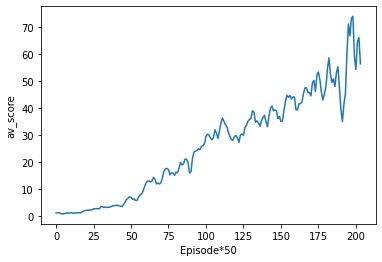

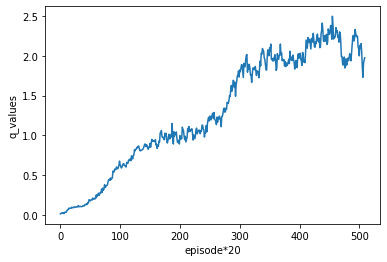

Game 10201, Score = 83.0,Steps = 1155, av_score=56.73
Game 10202, Score = 61.0,Steps = 710, av_score=56.85
Game 10203, Score = 44.0,Steps = 771, av_score=57.01
Game 10204, Score = 42.0,Steps = 610, av_score=56.62
Game 10205, Score = 33.0,Steps = 803, av_score=56.53
Game 10206, Score = 49.0,Steps = 832, av_score=54.62
Game 10207, Score = 39.0,Steps = 620, av_score=54.48
Game 10208, Score = 42.0,Steps = 681, av_score=54.52
Game 10209, Score = 40.0,Steps = 744, av_score=54.58
Game 10210, Score = 45.0,Steps = 653, av_score=54.31
Game 10211, Score = 140.0,Steps = 1076, av_score=55.23
Game 10212, Score = 46.0,Steps = 690, av_score=55.41
Game 10213, Score = 80.0,Steps = 883, av_score=55.8
Game 10214, Score = 143.0,Steps = 985, av_score=56.79
Game 10215, Score = 31.0,Steps = 874, av_score=56.6
Game 10216, Score = 44.0,Steps = 740, av_score=56.29
Game 10217, Score = 42.0,Steps = 766, av_score=54.46
Game 10218, Score = 60.0,Steps = 825, av_score=54.8
Game 10219, Score = 31.0,Steps = 671, av_scor

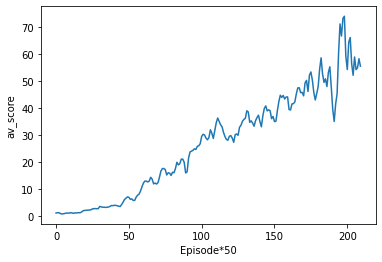

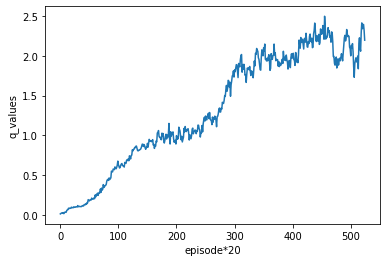

Game 10501, Score = 43.0,Steps = 858, av_score=55.41
Game 10502, Score = 61.0,Steps = 660, av_score=55.7
Game 10503, Score = 42.0,Steps = 774, av_score=55.77
Game 10504, Score = 7.0,Steps = 375, av_score=55.59
Game 10505, Score = 52.0,Steps = 850, av_score=55.37
Game 10506, Score = 44.0,Steps = 728, av_score=55.33
Game 10507, Score = 19.0,Steps = 480, av_score=54.98
Game 10508, Score = 55.0,Steps = 792, av_score=54.93
Game 10509, Score = 31.0,Steps = 730, av_score=54.98
Game 10510, Score = 33.0,Steps = 782, av_score=54.91
Game 10511, Score = 43.0,Steps = 777, av_score=54.86
Game 10512, Score = 39.0,Steps = 878, av_score=55.05
Game 10513, Score = 24.0,Steps = 507, av_score=54.93
Game 10514, Score = 31.0,Steps = 493, av_score=54.95
Game 10515, Score = 22.0,Steps = 646, av_score=54.46
Game 10516, Score = 41.0,Steps = 1004, av_score=53.71
Game 10517, Score = 48.0,Steps = 755, av_score=53.85
Game 10518, Score = 36.0,Steps = 958, av_score=53.7
Game 10519, Score = 76.0,Steps = 1133, av_score=

KeyboardInterrupt: ignored

In [ ]:

for n in range(x,n_ep):
    h=0
    
    score=0
    state=np.zeros((1,3*128))
    obs=env.reset()
    obs=obs.reshape(1,128)
    state=np.concatenate((state,obs/255),axis=1)
    done=False
    li=5
    while True:
        if(i<50000):
          eps=1
        elif(i<1050000):
          eps-=0.9/1000000
        elif(i<2050000):
          eps-=0.05/1000000
        action= agent.action( state, eps)
        next_obs,reward,done,_=env.step(action)
        lf=env.ale.lives()
        score+=reward
        next_obs=next_obs.reshape(1,128)
        if(li==lf):
            next_state=state[:,128:].copy()
            next_state=np.concatenate([next_state,next_obs/255.0], axis = 1)
            agent.remember(state,action,reward,next_state,done)
        else:
            li=lf
            next_state=np.zeros((1,3*128))
            next_state=np.concatenate([next_state,next_obs/255.0], axis = 1)
            agent.remember(state,action,reward,next_state,1)
        
        i+=1

        state=next_state.copy()
        h+=1
        if((i+1)>batch_size):
            agent.train()
        if done:
            break

    if((n+1)%20==0):
        with torch.no_grad():
            v=(torch.max(agent.model(test_states),1,keepdim=True)).values
        p.append(v.mean())

    scores.append(score)
    avg_reward = np.mean(scores)
    print('Game {}, Score = {},Steps = {}, av_score={}'.format(n+1,score,h,avg_reward))
    if((n+1)%50==0):
        s.append(avg_reward)
    if((n+1)%300==0): 
        plotter(s,p)    

Game 11736, Score = 35.0,Steps = 990, av_score=65.33
Game 11737, Score = 46.0,Steps = 1055, av_score=65.03
Game 11738, Score = 69.0,Steps = 919, av_score=65.07
Game 11739, Score = 108.0,Steps = 1135, av_score=65.33
Game 11740, Score = 143.0,Steps = 846, av_score=66.32
Game 11741, Score = 54.0,Steps = 994, av_score=66.29
Game 11742, Score = 268.0,Steps = 1207, av_score=68.11
Game 11743, Score = 31.0,Steps = 767, av_score=66.91
Game 11744, Score = 45.0,Steps = 930, av_score=67.02
Game 11745, Score = 9.0,Steps = 569, av_score=66.09
Game 11746, Score = 59.0,Steps = 738, av_score=66.0
Game 11747, Score = 48.0,Steps = 1055, av_score=65.92
Game 11748, Score = 88.0,Steps = 981, av_score=64.58
Game 11749, Score = 21.0,Steps = 457, av_score=62.81
Game 11750, Score = 33.0,Steps = 821, av_score=62.67
Game 11751, Score = 49.0,Steps = 736, av_score=62.7
Game 11752, Score = 41.0,Steps = 889, av_score=62.71
Game 11753, Score = 167.0,Steps = 1361, av_score=63.97
Game 11754, Score = 44.0,Steps = 968, av

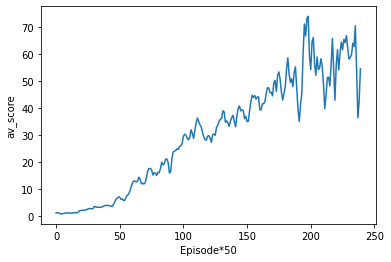

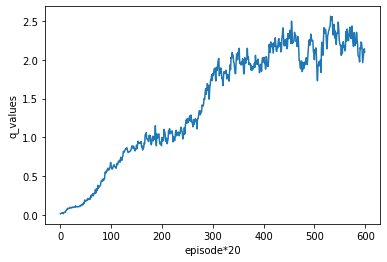

Game 12001, Score = 62.0,Steps = 1167, av_score=54.76
Game 12002, Score = 23.0,Steps = 613, av_score=54.6
Game 12003, Score = 55.0,Steps = 980, av_score=54.91
Game 12004, Score = 30.0,Steps = 598, av_score=54.93
Game 12005, Score = 24.0,Steps = 596, av_score=54.93
Game 12006, Score = 37.0,Steps = 717, av_score=54.87
Game 12007, Score = 46.0,Steps = 689, av_score=55.06
Game 12008, Score = 45.0,Steps = 1006, av_score=55.36
Game 12009, Score = 73.0,Steps = 1113, av_score=55.81
Game 12010, Score = 59.0,Steps = 936, av_score=56.29
Game 12011, Score = 33.0,Steps = 793, av_score=56.31
Game 12012, Score = 28.0,Steps = 626, av_score=56.27
Game 12013, Score = 31.0,Steps = 841, av_score=56.52
Game 12014, Score = 47.0,Steps = 749, av_score=56.67
Game 12015, Score = 62.0,Steps = 1237, av_score=56.84
Game 12016, Score = 69.0,Steps = 1097, av_score=57.02
Game 12017, Score = 22.0,Steps = 637, av_score=57.15
Game 12018, Score = 33.0,Steps = 675, av_score=57.05
Game 12019, Score = 148.0,Steps = 849, av_

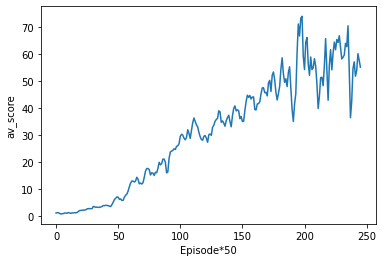

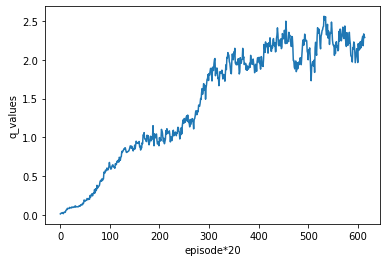

Game 12301, Score = 48.0,Steps = 989, av_score=55.26
Game 12302, Score = 35.0,Steps = 777, av_score=55.24
Game 12303, Score = 44.0,Steps = 808, av_score=55.36
Game 12304, Score = 24.0,Steps = 624, av_score=55.15
Game 12305, Score = 251.0,Steps = 1142, av_score=57.22
Game 12306, Score = 39.0,Steps = 718, av_score=57.06
Game 12307, Score = 32.0,Steps = 792, av_score=57.17
Game 12308, Score = 39.0,Steps = 1028, av_score=56.95
Game 12309, Score = 53.0,Steps = 706, av_score=57.1
Game 12310, Score = 49.0,Steps = 730, av_score=57.31
Game 12311, Score = 34.0,Steps = 779, av_score=57.28
Game 12312, Score = 58.0,Steps = 783, av_score=57.32
Game 12313, Score = 30.0,Steps = 740, av_score=57.26
Game 12314, Score = 30.0,Steps = 848, av_score=57.15
Game 12315, Score = 33.0,Steps = 729, av_score=56.97
Game 12316, Score = 42.0,Steps = 746, av_score=57.19
Game 12317, Score = 53.0,Steps = 810, av_score=57.17
Game 12318, Score = 42.0,Steps = 687, av_score=57.11
Game 12319, Score = 30.0,Steps = 930, av_sco

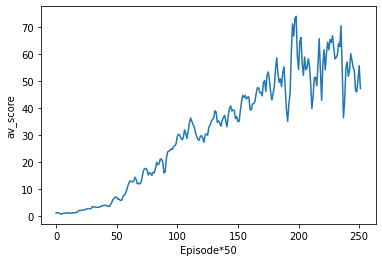

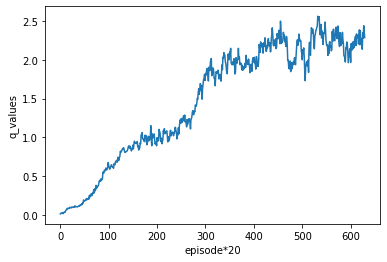

Game 12601, Score = 176.0,Steps = 846, av_score=48.46
Game 12602, Score = 23.0,Steps = 574, av_score=48.14
Game 12603, Score = 29.0,Steps = 935, av_score=47.64
Game 12604, Score = 26.0,Steps = 994, av_score=47.27
Game 12605, Score = 84.0,Steps = 1033, av_score=47.75
Game 12606, Score = 76.0,Steps = 1037, av_score=48.1
Game 12607, Score = 51.0,Steps = 944, av_score=48.28
Game 12608, Score = 33.0,Steps = 810, av_score=48.05
Game 12609, Score = 41.0,Steps = 940, av_score=48.13
Game 12610, Score = 38.0,Steps = 803, av_score=48.2
Game 12611, Score = 16.0,Steps = 447, av_score=47.82
Game 12612, Score = 115.0,Steps = 877, av_score=48.72
Game 12613, Score = 114.0,Steps = 1358, av_score=49.28
Game 12614, Score = 54.0,Steps = 1088, av_score=49.18
Game 12615, Score = 24.0,Steps = 631, av_score=48.12
Game 12616, Score = 269.0,Steps = 1238, av_score=50.49
Game 12617, Score = 16.0,Steps = 598, av_score=49.96
Game 12618, Score = 72.0,Steps = 932, av_score=50.26
Game 12619, Score = 41.0,Steps = 908, a

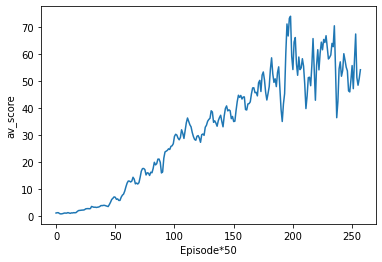

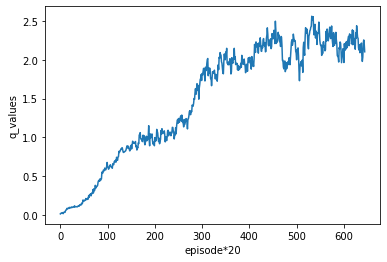

Game 12901, Score = 55.0,Steps = 1204, av_score=54.51
Game 12902, Score = 44.0,Steps = 922, av_score=54.62
Game 12903, Score = 53.0,Steps = 971, av_score=54.7
Game 12904, Score = 79.0,Steps = 1196, av_score=55.08
Game 12905, Score = 46.0,Steps = 1101, av_score=55.32
Game 12906, Score = 39.0,Steps = 598, av_score=55.36
Game 12907, Score = 79.0,Steps = 1023, av_score=55.88
Game 12908, Score = 100.0,Steps = 1108, av_score=56.36
Game 12909, Score = 32.0,Steps = 997, av_score=56.34
Game 12910, Score = 46.0,Steps = 1094, av_score=56.29
Game 12911, Score = 68.0,Steps = 880, av_score=56.83
Game 12912, Score = 52.0,Steps = 958, av_score=57.03
Game 12913, Score = 72.0,Steps = 1068, av_score=57.38
Game 12914, Score = 33.0,Steps = 1022, av_score=57.13
Game 12915, Score = 66.0,Steps = 1354, av_score=57.52
Game 12916, Score = 25.0,Steps = 728, av_score=57.47
Game 12917, Score = 78.0,Steps = 1081, av_score=55.76
Game 12918, Score = 42.0,Steps = 682, av_score=53.41
Game 12919, Score = 42.0,Steps = 779

KeyboardInterrupt: ignored

In [ ]:

for n in range(x,n_ep):
    h=0
    
    score=0
    state=np.zeros((1,3*128))
    obs=env.reset()
    obs=obs.reshape(1,128)
    state=np.concatenate((state,obs/255),axis=1)
    done=False
    li=5
    while True:
        if(i<50000):
          eps=1
        elif(i<1050000):
          eps-=0.9/1000000
        elif(i<2050000):
          eps-=0.05/1000000
        action= agent.action( state, eps)
        next_obs,reward,done,_=env.step(action)
        lf=env.ale.lives()
        score+=reward
        next_obs=next_obs.reshape(1,128)
        if(li==lf):
            next_state=state[:,128:].copy()
            next_state=np.concatenate([next_state,next_obs/255.0], axis = 1)
            agent.remember(state,action,reward,next_state,done)
        else:
            li=lf
            next_state=np.zeros((1,3*128))
            next_state=np.concatenate([next_state,next_obs/255.0], axis = 1)
            agent.remember(state,action,reward,next_state,1)
        
        i+=1

        state=next_state.copy()
        h+=1
        if((i+1)>batch_size):
            agent.train()
        if done:
            break

    if((n+1)%20==0):
        with torch.no_grad():
            v=(torch.max(agent.model(test_states),1,keepdim=True)).values
        p.append(v.mean())

    scores.append(score)
    avg_reward = np.mean(scores)
    print('Game {}, Score = {},Steps = {}, av_score={}'.format(n+1,score,h,avg_reward))
    if((n+1)%50==0):
        s.append(avg_reward)
    if((n+1)%300==0): 
        plotter(s,p)    

Game 10525, Score = 27.0,Steps = 768, av_score=51.5
Game 10526, Score = 32.0,Steps = 1033, av_score=51.21
Game 10527, Score = 46.0,Steps = 920, av_score=50.98
Game 10528, Score = 53.0,Steps = 1051, av_score=49.14
Game 10529, Score = 58.0,Steps = 904, av_score=48.75
Game 10530, Score = 30.0,Steps = 668, av_score=48.6
Game 10531, Score = 19.0,Steps = 696, av_score=47.86
Game 10532, Score = 43.0,Steps = 889, av_score=46.9
Game 10533, Score = 30.0,Steps = 1053, av_score=46.89
Game 10534, Score = 49.0,Steps = 997, av_score=46.96
Game 10535, Score = 44.0,Steps = 946, av_score=47.21
Game 10536, Score = 78.0,Steps = 1054, av_score=47.49
Game 10537, Score = 35.0,Steps = 1214, av_score=47.7
Game 10538, Score = 38.0,Steps = 790, av_score=47.84
Game 10539, Score = 28.0,Steps = 1065, av_score=48.02
Game 10540, Score = 29.0,Steps = 762, av_score=48.13
Game 10541, Score = 33.0,Steps = 801, av_score=48.06
Game 10542, Score = 44.0,Steps = 1074, av_score=47.91
Game 10543, Score = 22.0,Steps = 649, av_sc

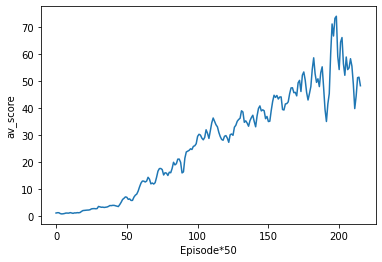

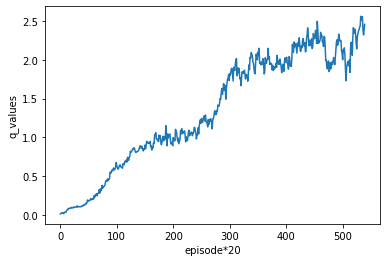

Game 10801, Score = 51.0,Steps = 924, av_score=48.23
Game 10802, Score = 78.0,Steps = 1045, av_score=48.19
Game 10803, Score = 47.0,Steps = 789, av_score=48.3
Game 10804, Score = 34.0,Steps = 951, av_score=48.3
Game 10805, Score = 43.0,Steps = 1045, av_score=47.99
Game 10806, Score = 150.0,Steps = 686, av_score=49.13
Game 10807, Score = 46.0,Steps = 934, av_score=48.82
Game 10808, Score = 238.0,Steps = 1068, av_score=50.91
Game 10809, Score = 45.0,Steps = 890, av_score=50.74
Game 10810, Score = 36.0,Steps = 803, av_score=50.87
Game 10811, Score = 36.0,Steps = 579, av_score=50.81
Game 10812, Score = 31.0,Steps = 816, av_score=50.57
Game 10813, Score = 42.0,Steps = 735, av_score=50.63
Game 10814, Score = 80.0,Steps = 1099, av_score=50.92
Game 10815, Score = 41.0,Steps = 828, av_score=51.06
Game 10816, Score = 46.0,Steps = 894, av_score=51.16
Game 10817, Score = 77.0,Steps = 864, av_score=51.41
Game 10818, Score = 69.0,Steps = 871, av_score=51.63
Game 10819, Score = 25.0,Steps = 481, av_s

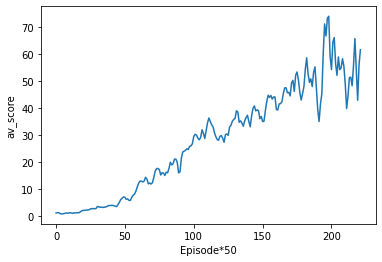

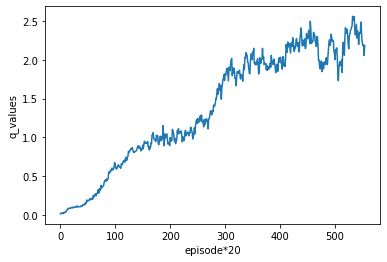

Game 11101, Score = 33.0,Steps = 813, av_score=61.34
Game 11102, Score = 75.0,Steps = 866, av_score=61.35
Game 11103, Score = 54.0,Steps = 966, av_score=61.52
Game 11104, Score = 41.0,Steps = 932, av_score=61.48
Game 11105, Score = 43.0,Steps = 1206, av_score=61.19
Game 11106, Score = 23.0,Steps = 682, av_score=61.16
Game 11107, Score = 44.0,Steps = 1016, av_score=60.81
Game 11108, Score = 110.0,Steps = 1212, av_score=61.61
Game 11109, Score = 29.0,Steps = 859, av_score=61.04
Game 11110, Score = 31.0,Steps = 721, av_score=60.78
Game 11111, Score = 23.0,Steps = 789, av_score=60.41
Game 11112, Score = 38.0,Steps = 891, av_score=60.37
Game 11113, Score = 29.0,Steps = 750, av_score=60.26
Game 11114, Score = 25.0,Steps = 770, av_score=59.67
Game 11115, Score = 38.0,Steps = 850, av_score=59.04
Game 11116, Score = 37.0,Steps = 1088, av_score=58.92
Game 11117, Score = 37.0,Steps = 792, av_score=58.93
Game 11118, Score = 40.0,Steps = 679, av_score=58.76
Game 11119, Score = 84.0,Steps = 864, av_

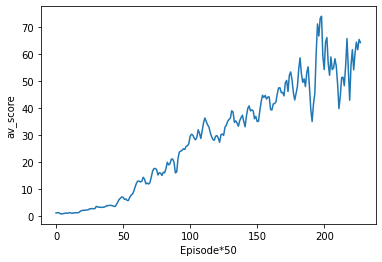

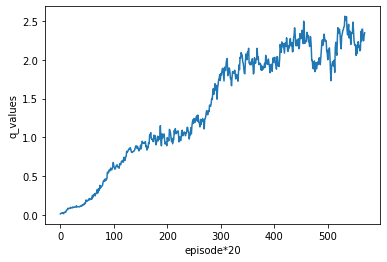

Game 11401, Score = 29.0,Steps = 608, av_score=61.9
Game 11402, Score = 23.0,Steps = 677, av_score=61.9
Game 11403, Score = 40.0,Steps = 773, av_score=62.04
Game 11404, Score = 273.0,Steps = 1129, av_score=64.41
Game 11405, Score = 79.0,Steps = 1046, av_score=63.75
Game 11406, Score = 47.0,Steps = 761, av_score=63.75
Game 11407, Score = 77.0,Steps = 934, av_score=64.19
Game 11408, Score = 34.0,Steps = 568, av_score=64.12
Game 11409, Score = 39.0,Steps = 863, av_score=63.84
Game 11410, Score = 85.0,Steps = 1054, av_score=63.2
Game 11411, Score = 26.0,Steps = 613, av_score=63.11
Game 11412, Score = 26.0,Steps = 552, av_score=62.96
Game 11413, Score = 56.0,Steps = 995, av_score=62.77
Game 11414, Score = 58.0,Steps = 745, av_score=62.76
Game 11415, Score = 31.0,Steps = 885, av_score=62.49
Game 11416, Score = 42.0,Steps = 985, av_score=62.49
Game 11417, Score = 74.0,Steps = 920, av_score=62.88
Game 11418, Score = 54.0,Steps = 954, av_score=62.93
Game 11419, Score = 227.0,Steps = 1357, av_sc

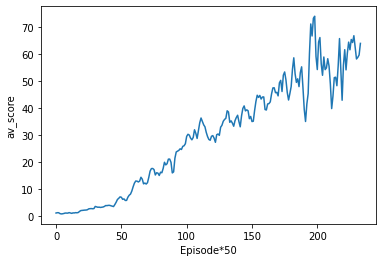

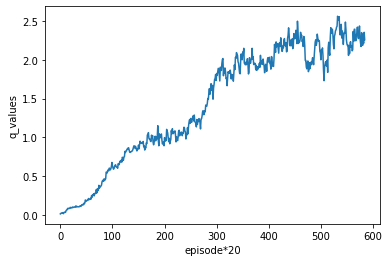

Game 11701, Score = 74.0,Steps = 857, av_score=64.39
Game 11702, Score = 44.0,Steps = 863, av_score=64.25
Game 11703, Score = 67.0,Steps = 905, av_score=64.41
Game 11704, Score = 41.0,Steps = 601, av_score=64.51
Game 11705, Score = 22.0,Steps = 606, av_score=64.32
Game 11706, Score = 60.0,Steps = 935, av_score=64.41
Game 11707, Score = 22.0,Steps = 803, av_score=62.27
Game 11708, Score = 36.0,Steps = 793, av_score=62.44
Game 11709, Score = 49.0,Steps = 878, av_score=62.41
Game 11710, Score = 24.0,Steps = 724, av_score=62.2
Game 11711, Score = 14.0,Steps = 353, av_score=61.77
Game 11712, Score = 37.0,Steps = 905, av_score=61.4
Game 11713, Score = 35.0,Steps = 936, av_score=61.39
Game 11714, Score = 49.0,Steps = 949, av_score=61.42
Game 11715, Score = 185.0,Steps = 1072, av_score=62.96
Game 11716, Score = 59.0,Steps = 1181, av_score=63.0
Game 11717, Score = 40.0,Steps = 772, av_score=62.42
Game 11718, Score = 27.0,Steps = 782, av_score=62.38
Game 11719, Score = 169.0,Steps = 1094, av_sco

KeyboardInterrupt: ignored

In [ ]:
eps=0.05
for n in range(x,n_ep):
    h=0
    
    score=0
    state=np.zeros((1,3*128))
    obs=env.reset()
    obs=obs.reshape(1,128)
    state=np.concatenate((state,obs/255),axis=1)
    done=False
    li=5
    while True:
        if(i<50000):
          eps=1
        elif(i<1050000):
          eps-=0.9/1000000
        elif(i<2050000):
          eps-=0.05/1000000
        action= agent.action( state, eps)
        next_obs,reward,done,_=env.step(action)
        lf=env.ale.lives()
        score+=reward
        next_obs=next_obs.reshape(1,128)
        if(li==lf):
            next_state=state[:,128:].copy()
            next_state=np.concatenate([next_state,next_obs/255.0], axis = 1)
            agent.remember(state,action,reward,next_state,done)
        else:
            li=lf
            next_state=np.zeros((1,3*128))
            next_state=np.concatenate([next_state,next_obs/255.0], axis = 1)
            agent.remember(state,action,reward,next_state,1)
        
        i+=1

        state=next_state.copy()
        h+=1
        if((i+1)>batch_size):
            agent.train()
        if done:
            break

    if((n+1)%20==0):
        with torch.no_grad():
            v=(torch.max(agent.model(test_states),1,keepdim=True)).values
        p.append(v.mean())

    scores.append(score)
    avg_reward = np.mean(scores)
    print('Game {}, Score = {},Steps = {}, av_score={}'.format(n+1,score,h,avg_reward))
    if((n+1)%50==0):
        s.append(avg_reward)
    if((n+1)%300==0): 
        plotter(s,p)    

In [ ]:
def record(out):
    image = env.unwrapped._get_image()
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    out.write(image)
    return out

In [ ]:
k=[]
eps=0.05
 
for n in range(0,100):
    h=0
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('/content/gdrive/My Drive/ataribreakout' + str(_) + '.avi',fourcc,20, (160, 210))
    score=0
    state=np.zeros((1,3*128))
    obs=env.reset()
    out = record(out)
    obs=obs.reshape(1,128)
    state=np.concatenate((state,obs/255),axis=1)
    done=False
    li=5
    while True:
        action= agent.action( state, eps)
        next_obs,reward,done,_=env.step(action)
        out = record(out)
        lf=env.ale.lives()
        score+=reward
        next_obs=next_obs.reshape(1,128)
        if(li==lf):
            next_state=state[:,128:].copy()
            next_state=np.concatenate([next_state,next_obs/255.0], axis = 1)
            
        else:
            li=lf
            next_state=np.zeros((1,3*128))
            next_state=np.concatenate([next_state,next_obs/255.0], axis = 1)
            
        
       
 
        state=next_state.copy()
        h+=1
        
        if done:
            break
    if(score>340):
        break
 
   
 
    k.append(score)
    avg_reward = np.mean(k)
    print('Game {}, Score = {},Steps = {}, av_score={}'.format(n+1,score,h,avg_reward))

Game 1, Score = 43.0,Steps = 1172, av_score=43.0
Game 2, Score = 49.0,Steps = 1217, av_score=46.0
Game 3, Score = 21.0,Steps = 642, av_score=37.666666666666664
Game 4, Score = 21.0,Steps = 642, av_score=33.5
Game 5, Score = 40.0,Steps = 1052, av_score=34.8
Game 6, Score = 71.0,Steps = 1055, av_score=40.833333333333336
Game 7, Score = 192.0,Steps = 1219, av_score=62.42857142857143
Game 8, Score = 139.0,Steps = 1315, av_score=72.0
Game 9, Score = 26.0,Steps = 753, av_score=66.88888888888889
Game 10, Score = 54.0,Steps = 911, av_score=65.6
Game 11, Score = 38.0,Steps = 844, av_score=63.09090909090909
Game 12, Score = 109.0,Steps = 1151, av_score=66.91666666666667
Game 13, Score = 181.0,Steps = 1237, av_score=75.6923076923077
Game 14, Score = 217.0,Steps = 947, av_score=85.78571428571429
Game 15, Score = 30.0,Steps = 826, av_score=82.06666666666666
Game 16, Score = 76.0,Steps = 1346, av_score=81.6875
Game 17, Score = 117.0,Steps = 1390, av_score=83.76470588235294
Game 18, Score = 46.0,Step

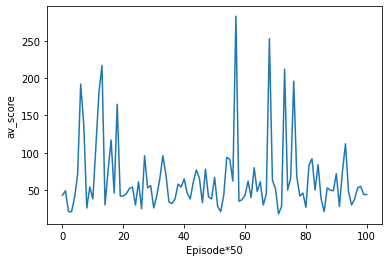

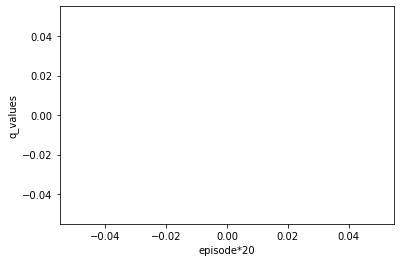

Game 100, Score = 44.0,Steps = 791, av_score=65.94059405940594


In [ ]:
k.append(score)
p=[]
plotter(k,p)
avg_reward = np.mean(k)
print('Game {}, Score = {},Steps = {}, av_score={}'.format(n+1,score,h,avg_reward))

In [ ]:
save_agent()
save_model()

In [ ]:
def load_model():
      model_save_name = 'breakout6.pt'
      path = F"/content/gdrive/My Drive/{model_save_name}" 
      checkpoint=torch.load(path)
      agent.model.load_state_dict(checkpoint['model_state_dict'])
      agent.target.load_state_dict(checkpoint['target_state_dict'])
      agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
      agent.memory=(checkpoint['memory'])


In [ ]:
def save_tests():
      model_save_name = 'breakout_test.pt'
      path = F"/content/gdrive/My Drive/{model_save_name}" 
      checkpoint = {
                      'test_states':test_states
                      }

      torch.save(checkpoint, path)